In [6]:
import_libraries = True

if import_libraries:
    
    import os
    import sys
    import os.path
    from pathlib import Path
    import rdflib
    from rdflib import Graph
    from typing import List, Dict, Any

    import json

    import numpy as np
    import laspy

    import open3d as o3d

    import matplotlib.pyplot as plt
    # from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
    from shapely.geometry import Polygon, MultiPolygon

    sys.path.append(r"C:\Users\oscar\anaconda3\envs\cvpr\Lib\site-packages\geomapi\utils")
    import geomapi.utils as ut
    from geomapi.utils import geometryutils as gmu
    from geomapi.nodes import PointCloudNode
    import geomapi.tools as tl

    from sklearn.utils import resample
    from scipy.spatial import  distance, ConvexHull,  QhullError
    from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
    from scipy.spatial import ConvexHull, QhullError

    from sklearn.linear_model import RANSACRegressor
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.decomposition import PCA

    import context_KUL
    import utils_KUL as kul
    # import utils_scan_to_edts as edts


In [7]:
output_folder_computation = True

if output_folder_computation:
        
    current_directory = Path(os.getcwd()) 
    print(f'Current directory: {current_directory}')

    data_base = Path.cwd().parents[0] / 'data'
    laz_files = list(data_base.glob('**/*.laz'))
    print(f'Found n. {len(laz_files)} in laz folder')

    output_base = Path.cwd().parents[0] / 'outputs' / 'edts'
    output_folder_root = output_base

    for laz_file in laz_files:
        
        name = laz_file.stem
        pcd_input_path = laz_file.parent

        print(f'\n--- Processing: {name} ---')
        print(f'Pcd_input_path: {pcd_input_path}')
        print(f'LAZ file: {laz_file}')

        output_json_root = output_folder_root / name / 'json'
        output_obj_root = output_folder_root / name / 'obj'
        output_ttl_root = output_folder_root / name / 'ttl'

        output_json_root.mkdir(parents=True, exist_ok=True)
        output_obj_root.mkdir(parents=True, exist_ok=True)
        output_ttl_root.mkdir(parents=True, exist_ok=True)  # ✅ TTL folder created

        output_json_walls_file = output_json_root / f'{name}_walls.json'
        output_json_walls_surfaces_file = output_json_root / f'{name}_walls_surfaces.json'
        output_json_floors_file = output_json_root / f'{name}_floors.json'
        output_json_columns_file = output_json_root / f'{name}_columns.json'
        output_json_openings_file = output_json_root / f'{name}_openings.json'
        output_json_devices_file = output_json_root / f'{name}_devices.json'

        output_json_adj_matrix_file = output_json_root / f'{name}_adj_matrix.json'
        output_json_adj_graph_file = output_json_root / f'{name}_adj_graph.json'

        geometry_output_bbox_path = output_obj_root / 'walls_obj'
        geometry_output_surfaces_path = output_obj_root / 'surfaces_obj'
        geometry_output_openings_path = output_obj_root / 'openings_obj'
        geometry_output_columns_bbox_path = output_obj_root / 'columns_obj'
        geometry_output_levels_bbox_path = output_obj_root / 'levels_obj'

        geometry_output_bbox_path.mkdir(parents=True, exist_ok=True)
        geometry_output_surfaces_path.mkdir(parents=True, exist_ok=True)
        geometry_output_openings_path.mkdir(parents=True, exist_ok=True)
        geometry_output_columns_bbox_path.mkdir(parents=True, exist_ok=True)

        graph_path_str = str(output_ttl_root / f'{name}_graph.ttl')

        print(f'JSON folder output: {output_json_root}')
        print(f'Walls file: {output_json_walls_file}')
        print(f'Walls surfaces file: {output_json_walls_surfaces_file}')
        print(f'Floors file: {output_json_floors_file}')
        print(f'Columns file: {output_json_columns_file}')
        print(f'Openings file: {output_json_openings_file}')
        print(f'Devices file: {output_json_devices_file}')

        print(f'Additional output paths:')
        print(f'geometry_output_bbox_path: {geometry_output_bbox_path}')
        print(f'geometry_output_surfaces_path: {geometry_output_surfaces_path}')
        print(f'geometry_output_openings_path: {geometry_output_openings_path}')
        print(f'geometry_output_columns_bbox_path: {geometry_output_columns_bbox_path}')
        print(f'TTL output folder: {output_ttl_root}')
        print(f'Graph TTL output path: {graph_path_str}')

    class_file = Path(os.getcwd()) / '_classes_expanded.json'
    print('class_file:', class_file)

    if not class_file.exists():
        print(f"class file not found: {class_file}")
    else:
        print(f"class file exists: {class_file}")


Current directory: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script
Found n. 15 in laz folder

--- Processing: 01 ---
Pcd_input_path: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data
LAZ file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\01.laz
JSON folder output: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\01\json
Walls file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\01\json\01_walls.json
Walls surfaces file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\01\json\01_walls_surfaces.json
Floors file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\01\json\01_floors.json
Columns file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\01\json\01_columns.json
Openings file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KU

In [8]:
from rdflib import Graph
from pathlib import Path

ttl_graph_reading = True

if ttl_graph_reading:
    
    path = current_directory.parents[0] / 'data'
    input_folder_ttl = path / 'graph_files'
    print('Input folder ttl:', input_folder_ttl)

    ttl_files = list(input_folder_ttl.glob('*.ttl'))
    ttl_list = []  
    names = []  # ✅ Collect names without '_graph.ttl'

    for ttl_file in ttl_files:
        print('Processing:', ttl_file)

        graph_path_uri = ttl_file.resolve().as_uri()
        print('TTL URI:', graph_path_uri)

        graph = Graph()
        graph.parse(graph_path_uri, format="turtle")
        print("Graph parsed successfully:", ttl_file.name)

        ttl_list.append(graph)

        # ✅ Strip '_graph.ttl' if present, else just remove '.ttl'
        base_name = ttl_file.stem
        if base_name.endswith('_graph'):
            base_name = base_name[:-6]  # remove '_graph'
        names.append(base_name)

    print("\n✅ TTL base names:")
    for name in names:
        print(name)
   

Input folder ttl: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\graph_files
Processing: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\graph_files\01a_graph.ttl
TTL URI: file:///C:/Users/oscar/OneDrive%20-%20Fondazione%20Bruno%20Kessler/KUL_GeometricModel/data/graph_files/01a_graph.ttl
Graph parsed successfully: 01a_graph.ttl
Processing: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\graph_files\01b_graph.ttl
TTL URI: file:///C:/Users/oscar/OneDrive%20-%20Fondazione%20Bruno%20Kessler/KUL_GeometricModel/data/graph_files/01b_graph.ttl
Graph parsed successfully: 01b_graph.ttl
Processing: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\graph_files\01_graph.ttl
TTL URI: file:///C:/Users/oscar/OneDrive%20-%20Fondazione%20Bruno%20Kessler/KUL_GeometricModel/data/graph_files/01_graph.ttl
Graph parsed successfully: 01_graph.ttl
Processing: c:\Users\oscar\OneDrive - Fondazione Bruno Kes

IMPORT GRAPH

In [9]:
class_dictionary_import = True

if class_dictionary_import:

    with open(class_file, 'r') as file:
        json_data = json.load(file)

    class_dict = {
        'classes': json_data.get('classes', []),
        'default': json_data.get('default', {}),
        'type': json_data.get('type', ''),
        'format': json_data.get('format', ''),
        'created_with': json_data.get('created_with', '')
    }

    print('Class dictionary:', class_dict)
    

Class dictionary: {'classes': [{'name': 'Unassigned', 'id': 255, 'temp_id': -1, 'color': '#9da2ab'}, {'name': 'Floors', 'id': 0, 'temp_id': 0, 'color': '#03c2fc'}, {'name': 'Ceilings', 'id': 1, 'temp_id': 1, 'color': '#e81416'}, {'name': 'Walls', 'id': 2, 'temp_id': 2, 'color': '#ffa500'}, {'name': 'Columns', 'id': 3, 'temp_id': 3, 'color': '#faeb36'}, {'name': 'Doors', 'id': 4, 'temp_id': 4, 'color': '#79c314'}, {'name': 'Windows', 'id': 5, 'temp_id': 5, 'color': '#4b369d'}, {'name': 'Lights', 'id': 6, 'temp_id': 6, 'color': '#7a93eb'}, {'name': 'Radiators', 'id': 7, 'temp_id': 7, 'color': '#d93b67'}, {'name': 'HVAC', 'id': 8, 'temp_id': 8, 'color': '#42b8a6'}], 'default': 255, 'type': 'semantic_segmentation', 'format': 'kitti', 'created_with': {'name': 'Saiga', 'version': '1.0.1'}}


IMPORT THE POINT CLOUD

In [10]:
for laz_file in laz_files:

    name = laz_file.stem
    pcd_input_path = laz_file.parent

    print(f'\n--- Processing: {name} ---')
    print(f'Pcd_input_path: {pcd_input_path}')
    print(f'LAZ file: {laz_file}')

    try:
        laz, pcd, pcd_nodes, normals = kul.load_point_cloud(laz_file)
        print(f'Las file: {laz}')
        print(f'PCD: {pcd}')
        print(f'PCD_Nodes: {pcd_nodes}')
        print(f'Normals: {normals}')
    except Exception as e:
        print(f'❌ Error loading point cloud for {name}: {e}')
        laz = None  

    matching_ttl = None
    for ttl_file in ttl_files:
        if name in ttl_file.stem:
            matching_ttl = ttl_file
            break

    if matching_ttl and matching_ttl.exists() and laz:
        try:
            node_groups, class_object_ids = kul.load_tt_graph(matching_ttl)
            print(f'✅ TTL file: {matching_ttl}')
            print(f'Node Groups: {node_groups}')
            print(f'Class Object IDs: {class_object_ids}')


            building_elements = kul.extract_objects_building(laz, matching_ttl)
            print(f'🏗️ Building Elements extracted: {building_elements}')

        except Exception as e:
            print(f'❌ Error processing TTL graph for {name}: {e}')
    else:
        print(f'⚠️ TTL file not found or point cloud loading failed for {name}')
        


--- Processing: 01 ---
Pcd_input_path: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data
LAZ file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\01.laz
Las file: <LasData(1.2, point fmt: <PointFormat(2, 2 bytes of extra dims)>, 7424963 points, 1 vlrs)>
PCD: PointCloud with 7424963 points.
PCD_Nodes: <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001CE66EAADC0>
Normals: [[-6.76488990e-04 -9.06718632e-01  4.21735538e-01]
 [-4.01606554e-01  9.00984233e-01  1.64132834e-01]
 [-5.71462660e-01 -7.11225837e-01  4.09375423e-01]
 ...
 [ 1.99412801e-01 -9.79699655e-01  2.05699206e-02]
 [-3.88641603e-01  9.21380417e-01  3.97898280e-03]
 [-3.30435542e-01  9.42357660e-01  5.26725038e-02]]
0 floors_nodes detected!
0 ceilings_nodes detected!
0 walls_nodes detected!
0 columns_nodes detected!
0 windows_nodes detected!
0 doors_nodes detected!
0 lights_nodes detected!
0 radiators_nodes detected!
0 hvac_nodes detected!
✅ TTL file: c:\Users

A - PROCESSING FLOORS AND CEILINGS

In [11]:
t_thickness_floor = 0.85
th_hull_area = 7.50
lof_neighbors = 20
downnsampling_factor = 10000
t_floor = 0.15
t_ceiling = 0.15
downsampling = 7500
downsample_ratio = 0.1


In [12]:
floor_ceilings_def =  True

if floor_ceilings_def:

    def planar_xy_hull(laz, node_ids, avg_z):

        points_2d = []
        
        for n in node_ids:
            # Since n is now a dictionary, access its class_id and object_id using dictionary keys
            idx = np.where((laz['classes'] == n['class_id']) & (laz['objects'] == n['object_id']))
            
            if idx[0].size == 0:
                continue  # Skip if no points are found for the given node_id
            
            # Extract x and y values for the selected points
            x_values = laz['x'][idx]
            y_values = laz['y'][idx]
            
            # Project to 2D by combining x and y values
            projected_points = np.column_stack((x_values, y_values))
            points_2d.extend(projected_points)
        
        # Convert list of 2D points to a numpy array
        points_2d = np.array(points_2d)
        
        # Ensure there are enough points to compute a convex hull
        if points_2d.shape[0] < 3:
            print(f"Not enough points to compute convex hull for avg_z {avg_z}\nN. of points {len(points_2d)}")
            return None
        
        try:

            hull = ConvexHull(points_2d)
            hull_area = hull.volume
            
            if hull_area >= th_hull_area:  # Only return the hull if the area is >= 1 m²
                return hull
            else:
                print(f"Hull area {hull_area:.2f} is less than 1 m² for avg_z {avg_z}")
                return None
        except QhullError:
            # Handle errors in case the convex hull computation fails
            print(f"QhullError for avg_z {avg_z}")
            return None

    def pointcloudnode_to_dict(node):
        return {
            'class_id': node.class_id,
            'object_id': node.object_id,
            'subject': node.subject
        }

    def convexhull_to_dict(hull):
        """Convert a ConvexHull object to a dictionary."""
        return {
            'points': hull.points.tolist(),  # Convert points array to a list
            'vertices': hull.vertices.tolist(),  # Convert vertices array to a list
            'simplices': hull.simplices.tolist() if hasattr(hull, 'simplices') else None,  # Convert simplices to a list if available
            'volume': hull.volume  # For 2D hulls, this is the area
        }

    def load_levels(laz, graph_path):
        # Parse the graph
        graph = Graph().parse(str(graph_path))
        nodes = tl.graph_to_nodes(graph)

        # Separate nodes by type
        ceilings_nodes = [n for n in nodes if 'ceilings' in n.subject.lower() and isinstance(n, PointCloudNode)]
        floors_nodes = [n for n in nodes if 'floors' in n.subject.lower() and isinstance(n, PointCloudNode)]
        level_nodes = [n for n in nodes if 'level' in n.subject.lower() and isinstance(n, PointCloudNode)]
        print("Ceilings:", [n.subject for n in ceilings_nodes])
        print("Floors:", [n.subject for n in floors_nodes])
        print("Levels:", [n.subject for n in level_nodes])

        # Initialize lists for merged floor and ceiling data
        floors_z = []
        ceilings_z = []
        
        # Lists to store z_min and z_max values for bounding box computation
        floors_z_bbox = []  # (z_min, z_max) for each floor
        ceilings_z_bbox = []  # (z_min, z_max) for each ceiling

        # Calculate average z-values and z_min, z_max for floors
        for n in floors_nodes:
            idx = np.where((laz.classes == n.class_id) & (laz.objects == n.object_id))
            z_values = laz.z[idx]

            if len(z_values) > 0:
                avg_z = np.mean(z_values)
                z_min = np.min(z_values)
                z_max = np.max(z_values)

                if (z_max - z_min) > t_thickness_floor:
                    print(f"Skipping node {n.subject} - z range too thick: {z_max - z_min:.2f}m")
                    continue
                
                merged = False
                for i, (existing_avg_z, floor_ids) in enumerate(floors_z):
                    if abs(existing_avg_z - avg_z) <= t_floor:
                        new_avg_z = (existing_avg_z * len(floor_ids) + avg_z) / (len(floor_ids) + 1)
                        floors_z[i] = (new_avg_z, floor_ids + [pointcloudnode_to_dict(n)])
                        floors_z_bbox[i] = (min(floors_z_bbox[i][0], z_min), max(floors_z_bbox[i][1], z_max))
                        merged = True
                        break

                if not merged:
                    floors_z.append((avg_z, [pointcloudnode_to_dict(n)]))
                    floors_z_bbox.append((z_min, z_max))  # Store z_min and z_max for this floor

        # Calculate average z-values and z_min, z_max for ceilings
        for n in ceilings_nodes:
            idx = np.where((laz.classes == n.class_id) & (laz.objects == n.object_id))
            z_values = laz.z[idx]

            if len(z_values) > 0:
                avg_z = np.mean(z_values)
                z_min = np.min(z_values)
                z_max = np.max(z_values)

                if (z_max - z_min) > t_thickness_floor:
                    continue

                merged = False
                for i, (existing_avg_z, ceiling_ids) in enumerate(ceilings_z):
                    if abs(existing_avg_z - avg_z) <= t_ceiling:
                        new_avg_z = (existing_avg_z * len(ceiling_ids) + avg_z) / (len(ceiling_ids) + 1)
                        ceilings_z[i] = (new_avg_z, ceiling_ids + [pointcloudnode_to_dict(n)])
                        ceilings_z_bbox[i] = (min(ceilings_z_bbox[i][0], z_min), max(ceilings_z_bbox[i][1], z_max))
                        merged = True
                        break

                if not merged:
                    ceilings_z.append((avg_z, [pointcloudnode_to_dict(n)]))
                    ceilings_z_bbox.append((z_min, z_max))  # Store z_min and z_max for this ceiling

        print(f'Find {len(ceilings_nodes)} ceilings after normalization {len(ceilings_z)}')
        print(f'Find {len(floors_nodes)} floors after normalization {len(floors_z)}')
        print(f'Find {len(level_nodes)} levels')

        # Compute convex hulls and bounding boxes
        floor_hulls = []
        floor_hull_vertices = []
        floor_bboxes = []

        for avg_z, floor_ids in floors_z:
            # Get the convex hull
            hull = planar_xy_hull(laz, floor_ids, avg_z)
            
            if hull is None:  # hulls with area < 1m² are already discarded in planar_xy_hull
                continue
            
            floor_hulls.append(convexhull_to_dict(hull))  # Convert hull to dict
            
            # Get the vertices of the convex hull
            vertices = hull.points[hull.vertices]
            floor_hull_vertices.append(vertices.tolist())  # Convert vertices to list
            
            # Compute the 2D bounding box
            min_x, max_x = np.min(vertices[:, 0]), np.max(vertices[:, 0])
            min_y, max_y = np.min(vertices[:, 1]), np.max(vertices[:, 1])

            # Extend to 3D bounding box using z_min and z_max
            z_min, z_max = None, None
            for i, (z_val, ids) in enumerate(floors_z):
                if abs(z_val - avg_z) < 1e-3:  # compare avg_z safely
                    z_min, z_max = floors_z_bbox[i]
                    break

            floor_bboxes.append(np.array([
                [min_x, min_y, z_min], [max_x, min_y, z_min],
                [max_x, max_y, z_min], [min_x, max_y, z_min],
                [min_x, min_y, z_max], [max_x, min_y, z_max],
                [max_x, max_y, z_max], [min_x, max_y, z_max]
            ]))


        ceiling_hulls = []
        ceiling_hull_vertices = []
        ceiling_bboxes = []

        for avg_z, ceiling_ids in ceilings_z:
            # Get the convex hull
            hull = planar_xy_hull(laz, ceiling_ids, avg_z)
            
            if hull is None:  
                continue
            
            ceiling_hulls.append(convexhull_to_dict(hull))  # Convert hull to dict

            # Get the vertices of the convex hull
            vertices = hull.points[hull.vertices]
            ceiling_hull_vertices.append(vertices.tolist())  # Convert vertices to list
            
            # Compute the 2D bounding box
            min_x, max_x = np.min(vertices[:, 0]), np.max(vertices[:, 0])
            min_y, max_y = np.min(vertices[:, 1]), np.max(vertices[:, 1])
            
            # Extend to 3D bounding box using z_min and z_max
            z_min, z_max = ceilings_z_bbox[ceilings_z.index((avg_z, ceiling_ids))]

            ceiling_bboxes.append(np.array([
                [min_x, min_y, z_min], [max_x, min_y, z_min],
                [max_x, max_y, z_min], [min_x, max_y, z_min],
                [min_x, min_y, z_max], [max_x, min_y, z_max],
                [max_x, max_y, z_max], [min_x, max_y, z_max]
            ]))

            
        # Compute average z-values for floors and ceilings
        floor_avg_z_values = [avg_z for avg_z, _ in floors_z]
        ceiling_avg_z_values = [avg_z for avg_z, _ in ceilings_z]

        floor_z_avg = np.mean(floor_avg_z_values) if floor_avg_z_values else None
        ceiling_z_avg = np.mean(ceiling_avg_z_values) if ceiling_avg_z_values else None


        thicknesses = []

        for floor_bbox, ceiling_bbox in zip(floors_z_bbox, ceilings_z_bbox):
            thickness = ceiling_bbox[0] - floor_bbox[1]  # z_min of ceiling - z_max of floor
            thicknesses.append(thickness)

        
        # Create and return the dictionary
        results = {
            'floors_nodes': floors_z,  # Now contains dictionaries instead of PointCloudNode objects
            'ceilings_nodes': ceilings_z,
            'floor_z_avg': floor_z_avg,
            'ceiling_z_avg': ceiling_z_avg,
            'level_nodes': [pointcloudnode_to_dict(n) for n in level_nodes],  # Convert level nodes to dictionaries
            'floors_z_bbox': floors_z_bbox,
            'ceilings_z_bbox': ceilings_z_bbox,
            'thicknesses': thicknesses,
            'floor_hulls': floor_hulls,  # Convex hulls for floors
            'floor_hull_vertices': floor_hull_vertices,  # Hull vertices for floors
            'ceiling_hulls': ceiling_hulls,  # Convex hulls for ceilings
            'ceiling_hull_vertices': ceiling_hull_vertices,  # Hull vertices for ceilings
            'floor_bboxes': floor_bboxes,  # 3D bounding boxes for floors
            'ceiling_bboxes': ceiling_bboxes  # 3D bounding boxes for ceilings
        }

        return results

    def levels_bbox(floor_bboxes, ceiling_bboxes):

        filtered_floor_bboxes = [bbox for bbox in floor_bboxes if bbox is not None]
        filtered_ceiling_bboxes = [bbox for bbox in ceiling_bboxes if bbox is not None]

        if len(filtered_floor_bboxes) == 0 and len(filtered_ceiling_bboxes) == 0:
            print("Both floor and ceiling bounding boxes are empty.")
            return np.array([])  # Return an empty array if both are empty

        if len(filtered_floor_bboxes) == 0:
            print("Floor bounding boxes are empty, only ceiling bounding boxes will be used.")
            return np.array(filtered_ceiling_bboxes)  # Return only ceiling bboxes if floors are empty

        if len(filtered_ceiling_bboxes) == 0:
            print("Ceiling bounding boxes are empty, only floor bounding boxes will be used.")
            return np.array(filtered_floor_bboxes)  # Return only floor bboxes if ceilings are empty

        floor_bboxes_array = np.array(filtered_floor_bboxes, dtype = object)
        ceiling_bboxes_array = np.array(filtered_ceiling_bboxes, dtype = object)

        levels_bboxes = np.concatenate((floor_bboxes_array, ceiling_bboxes_array), axis = 0)

        return levels_bboxes
    
    def plot_3d_bounding_boxes(results, bboxes, thicknesses=None):
    
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        floors_nodes = results['floors_nodes']
        ceilings_nodes = results['ceilings_nodes']     

        for n in floors_nodes and ceilings_nodes:

            idx = np.where((laz.classes == n.class_id) & (laz.objects == n.object_id))
            x_values = laz.x[idx]
            y_values = laz.y[idx]
            z_values = laz.z[idx]
            coords = np.vstack((x_values, y_values, z_values)).T

            ax.scatter(coords [:, 0], coords[:, 1], coords[:,2], marker = 'o', s = 0.001, alpha = 0.10)

        for bbox in bboxes:
            if bbox.shape == (8, 3):  # Ensure bbox has 8 points each with (x, y, z)
                # Define the vertices of the bounding box
                vertices = bbox
                
                faces = [
                    [vertices[0], vertices[1], vertices[5], vertices[4]],  # Bottom face
                    [vertices[7], vertices[6], vertices[2], vertices[3]],  # Top face
                    [vertices[0], vertices[1], vertices[6], vertices[7]],  # Front face
                    [vertices[2], vertices[3], vertices[4], vertices[5]],  # Back face
                    [vertices[0], vertices[3], vertices[7], vertices[4]],  # Left face
                    [vertices[1], vertices[2], vertices[6], vertices[5]]   # Right face
                ]
                
                poly3d = Poly3DCollection(faces, alpha=0.25, linewidths=0.5, edgecolors='r')
                ax.add_collection3d(poly3d)

        # If thicknesses are provided, plot them as well
        if thicknesses is not None and len(thicknesses) == 3:
            ax.quiver(0, 0, 0, thicknesses[0], thicknesses[1], thicknesses[2], color='b', label='Thickness')
            
            # Include thickness in axis labels
            ax.set_xlabel(f'x axis (thickness = {thicknesses[0]})', fontsize=6)
            ax.set_ylabel(f'y axis (thickness = {thicknesses[1]})', fontsize=6)
            ax.set_zlabel(f'z axis (thickness = {thicknesses[2]})', fontsize=6)
        else:
            # Default labels if thicknesses are not provided
            ax.set_xlabel('x axis', fontsize=6)
            ax.set_ylabel('y axis', fontsize=6)
            ax.set_zlabel('z axis', fontsize=6)
        
        # Set tick labels' font size
        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        ax.tick_params(axis='z', labelsize=6)

        # Optionally set axis limits based on the data
        x_limits = [np.min(bboxes[:, :, 0]) - 5, np.max(bboxes[:, :, 0]) + 5]
        y_limits = [np.min(bboxes[:, :, 1]) - 5, np.max(bboxes[:, :, 1]) + 5]
        z_limits = [np.min(bboxes[:, :, 2]), np.max(bboxes[:, :, 2])]

        ax.set_box_aspect([1, 1, 0.30])
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.set_zlim(z_limits)

        ax.grid(True)
        ax.grid(which = 'minor', linewidth = 0.25, color = 'gray')
        plt.title('3D BBOX FOR LEVELS NODES', fontsize=10)
        # plt.legend(loc='best')
        plt.show()
    
    def flatten_and_validate(vertices):
        """
        Validates and formats vertices as a 3D numpy array with shape (N, 3).
        Filters out any non-numeric entries and ensures each entry has exactly 3 values.
        """
        try:
            cleaned_vertices = []
            
            for v in vertices:
                if isinstance(v, dict):
                    try:
                        v = [float(v['x']), float(v['y']), float(v['z'])]
                    except (TypeError, ValueError, KeyError):
                        print(f"Skipping invalid dictionary entry in vertices: {v}")
                        continue

                if isinstance(v, (list, tuple, np.ndarray)) and len(v) == 3:
                    try:
                        v = [float(coord) for coord in v]
                        cleaned_vertices.append(v)
                    except (TypeError, ValueError):
                        print(f"Skipping invalid entry in vertices: {v}")
                        continue
            
            cleaned_vertices = np.array(cleaned_vertices)

            if cleaned_vertices.ndim != 2 or cleaned_vertices.shape[1] != 3:
                print(f"❌ Invalid shape after validation: expected (N, 3), got {cleaned_vertices.shape}")
                return None

            return cleaned_vertices

        except Exception as e:
            print(f"Validation failed for vertices: {str(e)}")
            return None


    def simplify_hull(vertices, max_vertices=40):
        """
        Simplifies vertices to a convex hull with a maximum of `max_vertices`.
        """
        try:
            if vertices is None or vertices.shape[0] < 3:
                print("Not enough points for a convex hull.")
                return None
            
            hull = ConvexHull(vertices[:, :2])
            hull_points = vertices[hull.vertices]
            
            if len(hull_points) > max_vertices:
                hull_points = hull_points[::len(hull_points) // max_vertices][:max_vertices]
            
            hull_points_3d = np.column_stack((hull_points[:, 0], hull_points[:, 1], np.mean(vertices[:, 2])))
            return hull_points_3d
        except Exception as e:
            print(f"Failed to simplify vertices to a convex hull: {str(e)}")
            return None

    def export_obj_floors_ceilings(results, output_obj_file):
        """
        Exports only floor and ceiling vertex data to an OBJ file, ignoring unrelated entries.
        """
        try:
            with open(output_obj_file, 'w') as f:
                vertex_offset = 1  # OBJ indexing starts at 1
                
                # Only process entries under 'floors' and 'ceilings'
                for level_type in ['floors_nodes', 'ceilings_nodes']:

                    if level_type not in results:
                        continue  # Skip if the expected data type is missing

                    level_data = results[level_type]
                    
                    # Ensure level_data is a list to iterate through
                    if not isinstance(level_data, list):
                        print(f"Skipping {level_type}: unsupported data format")
                        continue
                    
                    for i, element in enumerate(level_data):
                        # Validate that each element has vertices
                        vertices = element.get("vertices", []) if isinstance(element, dict) else element
                        vertices = flatten_and_validate(vertices)

                        if vertices is None or vertices.size == 0:
                            print(f"Skipping {level_type}_{i + 1}: invalid or empty vertices")
                            continue

                        # Simplify hull for the element
                        simplified_vertices = simplify_hull(vertices)
                        if simplified_vertices is None:
                            print(f"Skipping {level_type}_{i + 1} after simplification.")
                            continue

                        # Write vertices to OBJ file
                        f.write(f"# {level_type.capitalize()}_{i + 1}\n")
                        for vertex in simplified_vertices:
                            f.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

                        # Write faces (assuming quads)
                        if len(simplified_vertices) == 4:
                            f.write(f"f {vertex_offset} {vertex_offset+1} {vertex_offset+2} {vertex_offset+3}\n")
                        vertex_offset += len(simplified_vertices)

            print(f"Floors and ceilings successfully exported to {output_obj_file}")
        except Exception as e:
            print(f"Failed to export floors and ceilings to OBJ: {str(e)}")

    def export_floors_ceilings_levels_to_json(results, output_json_file):
        try:
            with open(output_json_file, 'w') as f:
                json.dump(results, f, indent=4)
            print(f"Data successfully written to {output_json_file}")
        except Exception as e:
            print(f"Failed to write data to JSON: {str(e)}")


In [13]:
floor_ceilings_computation = True

if floor_ceilings_computation:

    for laz_file in laz_files:
        
        name = laz_file.stem
        print(f'\n--- Floor/Ceiling Analysis for: {name} ---')

        try:
            laz, pcd, pcd_nodes, normals = kul.load_point_cloud(laz_file)
        except Exception as e:
            print(f'❌ Could not load point cloud for {name}: {e}')
            continue

        matching_ttl = next((ttl for ttl in ttl_files if name in ttl.stem), None)
        if not matching_ttl or not matching_ttl.exists():
            print(f'⚠️ No matching TTL file found for {name}')
            continue

        try:
            levels_data = load_levels(laz, matching_ttl)

            floor_bboxes = levels_data.get('floor_bboxes', [])
            ceiling_bboxes = levels_data.get('ceiling_bboxes', [])
            thicknesses = levels_data.get('thicknesses', [])
            floor_z_avg = levels_data.get('floor_z_avg')
            ceiling_z_avg = levels_data.get('ceiling_z_avg')

            print(f'\n📐 floor_bboxes: {len(floor_bboxes)} found')
            if floor_bboxes:
                print(f'🧱 Sample floor bbox: {floor_bboxes[0]}')

            print(f'📐 ceiling_bboxes: {len(ceiling_bboxes)} found')
            if ceiling_bboxes:
                print(f'🧱 Sample ceiling bbox: {ceiling_bboxes[0]}')

            level_bboxes = levels_bbox(floor_bboxes, ceiling_bboxes)
            print(f'\n📦 Total combined level bounding boxes: {len(level_bboxes)}')
            if level_bboxes.any():
                print(f'🧊 First bbox: {level_bboxes[0]}')

            print(f'📏 Floor avg Z: {floor_z_avg:.2f}' if floor_z_avg else "No floor avg Z")
            print(f'📏 Ceiling avg Z: {ceiling_z_avg:.2f}' if ceiling_z_avg else "No ceiling avg Z")
            print(f'🧱 Level thicknesses: {thicknesses}')

            # Debugging print
            floor_bboxes_np = np.array(floor_bboxes)
            ceiling_bboxes_np = np.array(ceiling_bboxes)
            print('floors', floor_bboxes_np)
            print('ceiling', ceiling_bboxes_np)

            levels_bboxes_array = np.array(level_bboxes, dtype=float)
            print(f'Levels: {levels_bboxes_array} Number of levels: {len(levels_bboxes_array)}')

            plot = False
            
            if plot:
                plot_3d_bounding_boxes(levels_data, levels_bboxes_array)

            export_floors_ceilings_levels_to_json(levels_data, output_json_floors_file)
            export_obj_floors_ceilings(levels_data, geometry_output_levels_bbox_path)

        except Exception as e:
            print(f'❌ Error computing levels for {name}: {e}')
            


--- Floor/Ceiling Analysis for: 01 ---
Ceilings: [rdflib.term.URIRef('file:///ceilings_1')]
Floors: [rdflib.term.URIRef('file:///floors_0')]
Levels: []
Skipping node file:///floors_0 - z range too thick: 3.16m
Find 1 ceilings after normalization 0
Find 1 floors after normalization 0
Find 0 levels

📐 floor_bboxes: 0 found
📐 ceiling_bboxes: 0 found
Both floor and ceiling bounding boxes are empty.

📦 Total combined level bounding boxes: 0
No floor avg Z
No ceiling avg Z
🧱 Level thicknesses: []
floors []
ceiling []
Levels: [] Number of levels: 0
Data successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\first_floor_CUT\json\first_floor_CUT_floors.json
Floors and ceilings successfully exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\first_floor_CUT\obj\levels_obj

--- Floor/Ceiling Analysis for: 01a ---
Ceilings: [rdflib.term.URIRef('file:///ceilings_1')]
Floors: [rdflib.term.URIRef('file:///

B - PROCESSING WALLS

In [14]:
process_walls_nodes_complete = True

if process_walls_nodes_complete:

    import numpy as np
    from scipy.spatial import ConvexHull
    from rdflib import Graph
    import json
    import laspy

    # Optional: External dependency check
    try:
        import open3d as o3d
    except ImportError:
        print("⚠️ open3d not installed — some functions like bounding_boxes won't work")


    def find_matching_ttl(name, ttl_folder):
        name = name.lower().rstrip("_")
        matches = [ttl for ttl in ttl_folder.glob("*.ttl") if name in ttl.stem.lower()]
        if matches:
            return sorted(matches, key=lambda t: len(t.stem))[0]
        return None

    def object_points(laz, graph_path):
        graph = Graph().parse(str(graph_path))
        nodes = tl.graph_to_nodes(graph)
        wall_nodes = [n for n in nodes if isinstance(n, PointCloudNode) and 'wall' in n.subject.lower()]
        print(f"🧱 Wall node subjects: {[n.subject for n in wall_nodes]}")

        wall_coordinates = []
        idx_list = []
        for wall in wall_nodes:
            try:
                idx = np.where((laz.classes == wall.class_id) & (laz.objects == wall.object_id))
                if len(idx[0]) > 0:
                    coords = np.vstack((laz.x[idx], laz.y[idx], laz.z[idx])).T
                    wall_coordinates.append(coords)
                    idx_list.append(idx)
            except AttributeError:
                print(f"⚠️ Skipping wall {wall.subject} — missing class_id/object_id")
                continue
        return wall_coordinates, wall_nodes, idx_list

    def extract_min_max_z_from_bboxes(bboxes):
        z_values = []
        for bbox in bboxes:
            bbox = np.asarray(bbox)
            if bbox.ndim == 2 and bbox.shape[1] == 3:
                z_values.extend(bbox[:, 2])
        if z_values:
            return np.min(z_values), np.max(z_values)
        return None, None

    
    def compute_bounding_box(points):
        
        pi2 = np.pi/2.

        # get the convex hull for the points
        hull_points = points[ConvexHull(points).vertices]

        # calculate edge angles
        edges = np.zeros((len(hull_points)-1, 2))
        edges = hull_points[1:] - hull_points[:-1]

        angles = np.zeros((len(edges)))
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)

        # find rotation matrices
        # XXX both work
        rotations = np.vstack([np.cos(angles), np.cos(angles - pi2), np.cos(angles + pi2),np.cos (angles)]).T
        rotations = rotations.reshape((-1, 2, 2))

        # Covariance matrix
        cov = np.cov(points, rowvar=False)
        
        # apply rotations to the Hull points
        rot_points = np.dot(rotations, hull_points.T)

        # find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)

        # find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)

        # return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        r = rotations[best_idx]

        rval = np.zeros((4, 2))
        rval[0] = np.dot([x1, y2], r)
        rval[1] = np.dot([x2, y2], r)
        rval[2] = np.dot([x2, y1], r)
        rval[3] = np.dot([x1, y1], r)

        return rval, r


    def compute_wall_bbox(points_3d):

        points = np.asarray(points_3d)
        min_z, max_z = np.min(points[:, 2]), np.max(points[:, 2])
        base_2d, rot = compute_bounding_box(points[:, :2])
        base_3d = np.column_stack((base_2d, np.full(4, min_z)))
        top_3d = np.column_stack((base_2d, np.full(4, max_z)))
        return base_3d, top_3d, rot

    def sort_counterclockwise(pts):
        center = np.mean(pts[:, :2], axis=0)
        angles = np.arctan2(pts[:, 1] - center[1], pts[:, 0] - center[0])
        return pts[np.argsort(angles)]

    def is_valid_3d_wall(points):
        try:
            return points.shape[0] >= 4 and ConvexHull(points)
        except:
            return False

    def is_box_like(vertices):
        if len(vertices) != 8:
            return False
        vertices = np.array(vertices)
        base, top = vertices[:4], vertices[4:]
        def is_rectangle(quad):
            edges = [np.linalg.norm(quad[i] - quad[(i + 1) % 4]) for i in range(4)]
            return np.isclose(edges[0], edges[2]) and np.isclose(edges[1], edges[3])
        return is_rectangle(base) and is_rectangle(top)

    def compute_features_walls_bbox(base, top, idx):
        center = np.mean(np.vstack((base, top)), axis=0)
        height = abs(np.mean(top[:, 2]) - np.mean(base[:, 2]))
        edge_lengths = [np.linalg.norm(base[i] - base[(i + 1) % 4]) for i in range(4)]
        return {
            "wall_index": idx,
            "center": center.tolist(),
            "height": float(height),
            "thickness": float(min(edge_lengths)),
            "length": float(max(edge_lengths)),
            "vertices": np.vstack((base, top)).tolist()
        }
    
    def compute_3d_features(laz, wall_coordinates, rotated_boxes, rotation_matrices, graph_path, floor_bboxes, ceiling_bboxes):

        all_base_vertices = []
        all_top_vertices = []
        wall_properties = []

        for i, wall_points in enumerate(wall_coordinates):
            wall_points = np.array(wall_points)

            if wall_points.ndim != 2 or wall_points.shape[1] < 3:
                print(f"⚠️ Skipping Wall {i}: invalid shape {wall_points.shape}")
                continue

            print(f"Coordinates for Wall {i}:\n", wall_points)

            z_values = wall_points[:, 2]
            min_z = np.min(z_values)
            max_z = np.max(z_values)

            rotated_box = rotated_boxes[i]
            rotation_matrix = rotation_matrices[i]

            if rotated_box.shape[1] != 2:
                raise ValueError(f"rotated_box for Wall {i} does not have the correct shape: {rotated_box.shape}")

            center_r = np.mean(rotated_box, axis=0)
            center = np.array([center_r[0], center_r[1], 0])

            A, B, C, D = rotated_box
            a = B - A
            b = C - B
            c = D - C
            d = A - D
            edges = np.vstack([a, b, c, d])

            angle = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
            rotation = np.degrees(angle)
            length = np.max(np.linalg.norm(edges, axis=1))

            floor_z_min, floor_z_max = extract_min_max_z_from_bboxes(floor_bboxes)
            ceiling_z_min, ceiling_z_max = extract_min_max_z_from_bboxes(ceiling_bboxes)

            z_base = floor_z_min if floor_z_min is not None else min_z
            z_top = ceiling_z_max if ceiling_z_max is not None else max_z
            height = z_top - z_base

            # 3D base and top
            A_3d_base = np.append(A, z_base)
            B_3d_base = np.append(B, z_base)
            C_3d_base = np.append(C, z_base)
            D_3d_base = np.append(D, z_base)

            A_3d_top = np.append(A, z_top)
            B_3d_top = np.append(B, z_top)
            C_3d_top = np.append(C, z_top)
            D_3d_top = np.append(D, z_top)

            base_vertices = np.array([A_3d_base, B_3d_base, C_3d_base, D_3d_base])
            top_vertices = np.array([A_3d_top, B_3d_top, C_3d_top, D_3d_top])

            all_base_vertices.append(base_vertices)
            all_top_vertices.append(top_vertices)

            vertices = np.vstack([base_vertices, top_vertices])
            distances = [np.linalg.norm(vertices[i] - vertices[j])
                        for i in range(len(vertices)) for j in range(i + 1, len(vertices))]
            thickness = min(distances)

            # ✅ Compute additional fields
            base_center_line = [(A_3d_base + D_3d_base) / 2, (B_3d_base + C_3d_base) / 2]
            top_center_line = [(A_3d_top + D_3d_top) / 2, (B_3d_top + C_3d_top) / 2]
            surface_vertices = [A_3d_top.tolist(), B_3d_top.tolist(), C_3d_base.tolist(), D_3d_base.tolist()]

            wall_properties.append({
                'length': length,
                'thickness': thickness,
                'height': height,
                'center': center.tolist(),
                'rotation': float(rotation),
                'base_center_lines': [p.tolist() for p in base_center_line],
                'top_center_lines': [p.tolist() for p in top_center_line],
                'surface_vertices': surface_vertices
            })

            print(f'Wall {i}: Thickness: {thickness}\n Length: {length}\n z_base: {z_base}, z_top: {z_top}\n Height: {height}\n Location: {center}\n Rotation: {rotation}')

        return all_base_vertices, all_top_vertices, wall_properties

    def export_obj_walls(wall_results, output_path):
        with open(output_path, 'w') as f:
            vertex_offset = 1
            for wall in wall_results:
                vertices = np.array(wall.get("vertices"))
                if not is_box_like(vertices):
                    continue
                for v in vertices:
                    f.write(f"v {v[0]} {v[1]} {v[2]}\n")
                faces = [[0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4], [1, 2, 6, 5], [2, 3, 7, 6], [3, 0, 4, 7]]
                for face in faces:
                    f.write(f"f {' '.join(str(vertex_offset + i) for i in face)}\n")
                vertex_offset += 8
        print(f"✅ Exported OBJ: {output_path}")

    def export_walls_to_json(results, output_path):
        def convert(obj):
            if isinstance(obj, np.ndarray): return obj.tolist()
            if isinstance(obj, dict): return {k: convert(v) for k, v in obj.items()}
            if isinstance(obj, list): return [convert(i) for i in obj]
            return obj
        with open(output_path, 'w') as f:
            json.dump(convert(results), f, indent=4)
        print(f"✅ Exported JSON: {output_path}")




    ##__________________________
    laz_files = list(data_base.glob('**/*.laz'))
    print(laz_files)

    all_walls_results = {}
    wall_coords_dict = {}
    wall_bbox_vertices_dict = {}

    for laz_file in laz_files:

        name = laz_file.stem  # do not strip anything
        print(f"\n📂 Processing: {name}")

        try:
            laz = laspy.read(laz_file)
            matching_ttl = find_matching_ttl(name, input_folder_ttl)

            if not matching_ttl:
                print(f"⚠️ Skipping {name}: no TTL file found.")
                continue

            levels_data = load_levels(laz, matching_ttl)
            wall_data = object_points(laz, matching_ttl)

            if not wall_data or len(wall_data) != 3:
                print(f"⚠️ Skipping {name}: object_points() returned invalid result")
                continue

            wall_coords, wall_nodes, _ = wall_data
            min_pts_per_wall = 600

            filtered = [
                (wc, wn) for wc, wn in zip(wall_coords, wall_nodes)
                if is_valid_3d_wall(wc) and len(wc) >= min_pts_per_wall
            ]
            if not filtered:
                print(f"⚠️ No valid wall groups found in {name}")
                all_walls_results[name] = []
                continue

            wall_coords_filtered, wall_nodes_filtered = zip(*filtered)
            wall_coords_filtered = list(wall_coords_filtered)
            wall_coords_dict[name] = wall_coords_filtered

            # Bounding box computation
            base_vertices = []
            top_vertices = []
            rotation_matrices = []
            rotated_boxes_2d = []
            wall_bbox_verts = []

            for idx, wall in enumerate(wall_coords_filtered):
                try:
                    wall_np = np.asarray(wall)
                    if wall_np.shape != (wall_np.shape[0], 3):
                        print(f"⚠️ Wall {idx} has invalid shape {wall_np.shape}")
                        continue

                    base, top, rot = compute_wall_bbox(wall_np)
                    combined = np.vstack((base, top))

                    if combined.shape != (8, 3):
                        print(f"⚠️ Invalid box shape for Wall {idx}: {combined.shape}")
                        continue

                    base_vertices.append(base)
                    top_vertices.append(top)
                    rotation_matrices.append(rot)
                    rotated_boxes_2d.append(base[:, :2])
                    wall_bbox_verts.append(combined)

                    print(f"✅ Wall {idx} OK — shape: {combined.shape}")
                except Exception as e:
                    print(f"❌ Bounding box error on Wall {idx}: {e}")

            # 3D Feature Extraction
            base_vertices, top_vertices, wall_props = compute_3d_features(
                laz, wall_coords_filtered, rotated_boxes_2d, rotation_matrices,
                matching_ttl, levels_data['floor_bboxes'], levels_data['ceiling_bboxes']
            )

            walls_results = []

            seen = set()  # to avoid duplicates
            for i, (base, top) in enumerate(zip(base_vertices, top_vertices)):
                try:
                    result = compute_features_walls_bbox(base, top, i)
                    result.update(wall_props[i])
                    result["wall_id"] = i
                    result["surface_vertices"] = np.vstack((base, top)).tolist()
                    result["base_line"] = {"start": base[0].tolist(), "end": base[1].tolist()}
                    result["top_center_lines"] = [top[0].tolist(), top[1].tolist()]
                    result["base_center_lines"] = [base[0].tolist(), base[1].tolist()]

                    # Final check for box integrity
                    key = tuple(map(tuple, result["vertices"]))
                    if not is_box_like(result["vertices"]) or key in seen:
                        print(f"⚠️ Skipping duplicate or invalid box (Wall {i})")
                        continue

                    seen.add(key)
                    walls_results.append(result)
                except Exception as e:
                    print(f"❌ Failed to build wall {i}: {e}")

            all_walls_results[name] = walls_results
            wall_bbox_vertices_dict[name] = wall_bbox_verts

            output_subfolder = output_json_root / name
            output_subfolder.mkdir(parents=True, exist_ok=True)

            (geometry_output_bbox_path / name).mkdir(parents=True, exist_ok=True)  # ✅ Move here

            export_obj_walls(walls_results, geometry_output_bbox_path / name / f"{name}_walls.obj")
            export_walls_to_json(all_walls_results, output_subfolder / f"{name}_walls.json")
            export_walls_to_json(walls_results, output_subfolder / f"{name}_walls_surfaces.json")

            print(f"✅ Exported {len(walls_results)} walls for '{name}'")


            print(f"✅ Exported {len(walls_results)} walls for '{name}'")

        except Exception as e:
            print(f"❌ Error processing '{name}': {e}")


[WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/data/01.laz'), WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/data/01a.laz'), WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/data/01b.laz'), WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/data/block_N_1.laz'), WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/data/block_N_2.laz'), WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/data/block_N_3.laz'), WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/data/block_N_3b.laz'), WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/data/block_N_4.laz'), WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/data/first_floor.laz'), WindowsPath('c:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_Ge

CHECK OVERLAPPING

✅ Plotting wall data for: '01' (matched from '01')


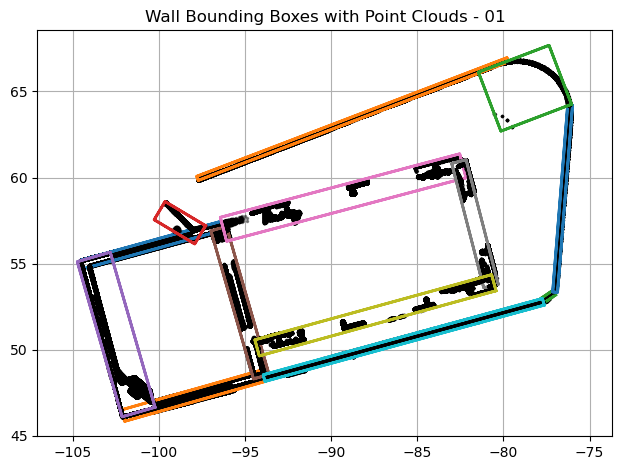

✅ Plotting wall data for: '01a' (matched from '01a')


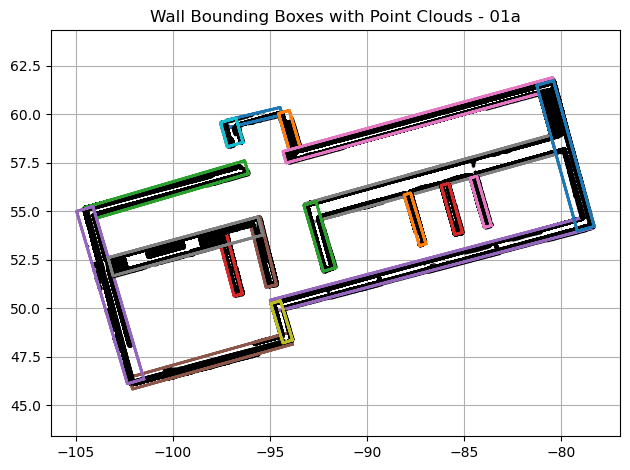

✅ Plotting wall data for: '01b' (matched from '01b')


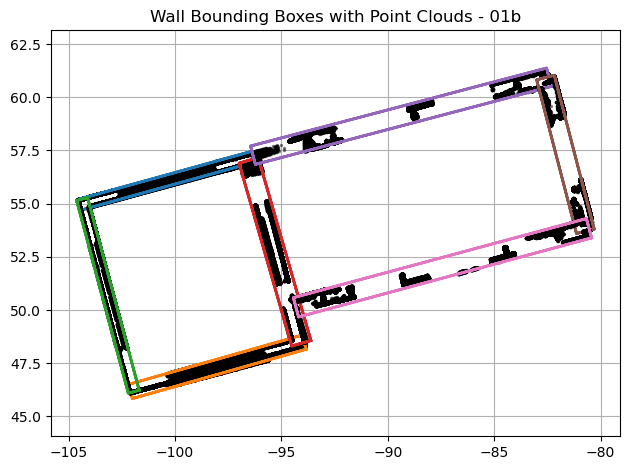

✅ Plotting wall data for: 'block_N_1' (matched from 'block_n_1')


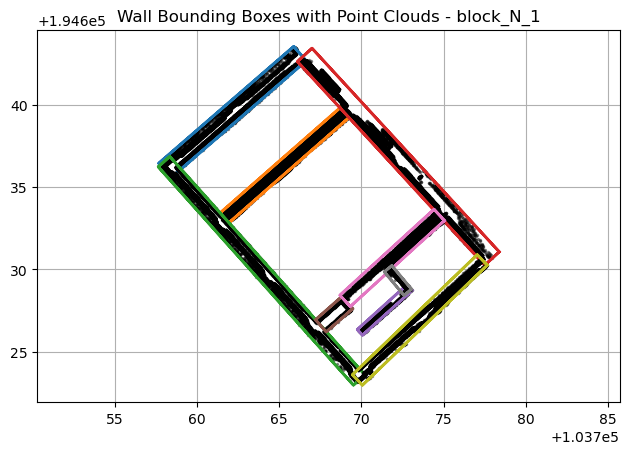

✅ Plotting wall data for: 'block_N_2' (matched from 'block_n_2')


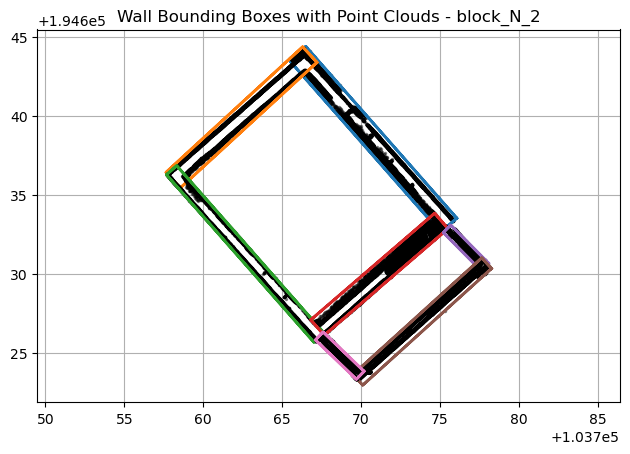

✅ Plotting wall data for: 'block_N_3' (matched from 'block_n_3')


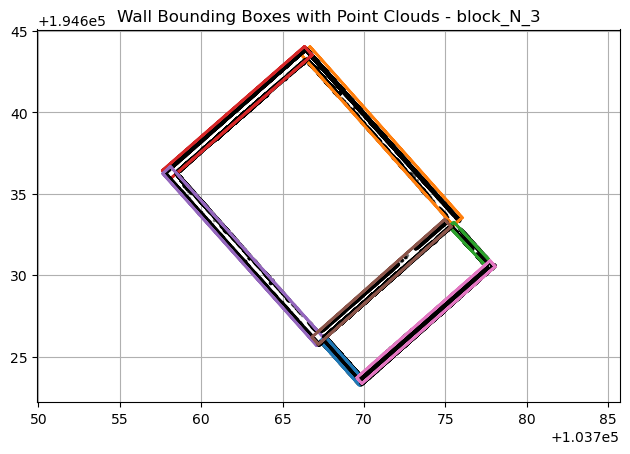

✅ Plotting wall data for: 'block_N_3b' (matched from 'block_n_3b')


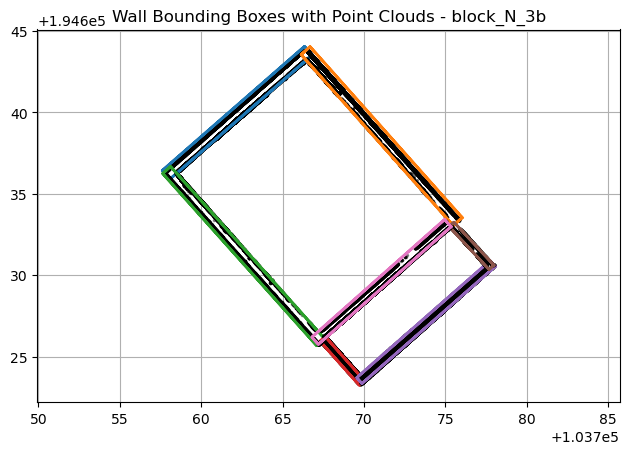

✅ Plotting wall data for: 'block_N_4' (matched from 'block_n_4')


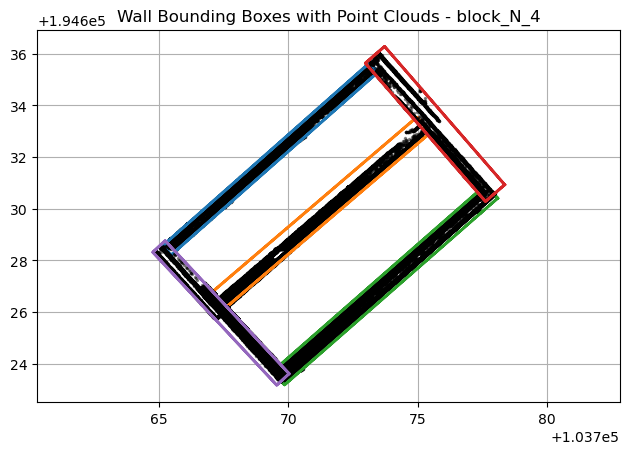

✅ Plotting wall data for: 'first_floor' (matched from 'first_floor')


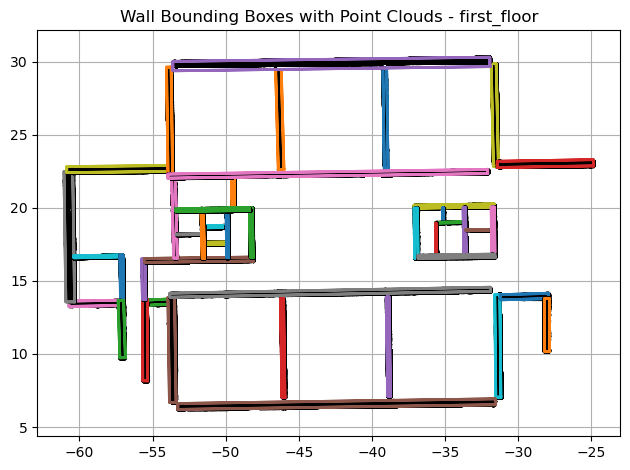

✅ Plotting wall data for: 'house_01_' (matched from 'house_01_')


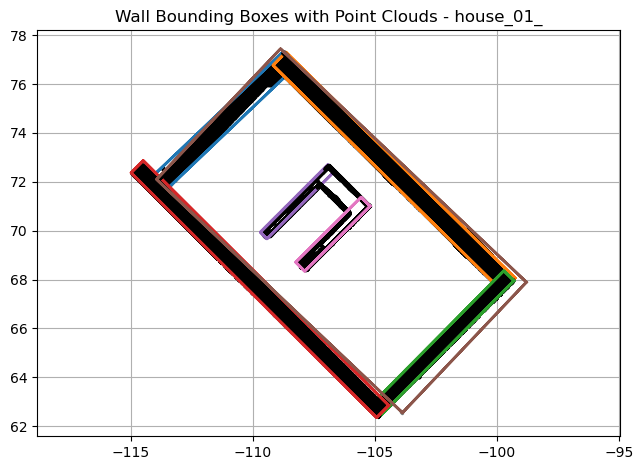

✅ Plotting wall data for: 'sc_1stwing' (matched from 'sc_1stwing')


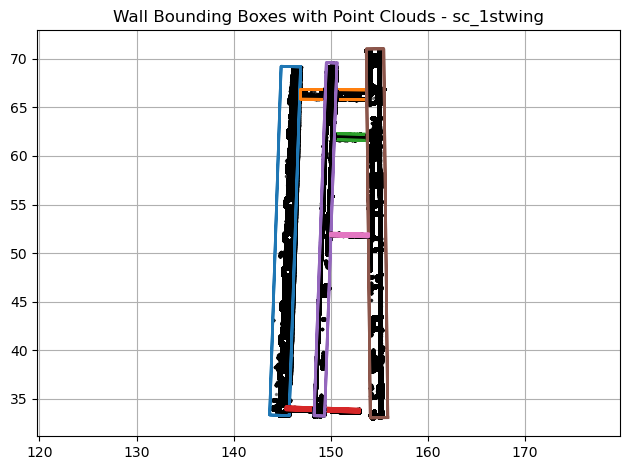

✅ Plotting wall data for: 'block_N_1' (matched from 'block_n_1')


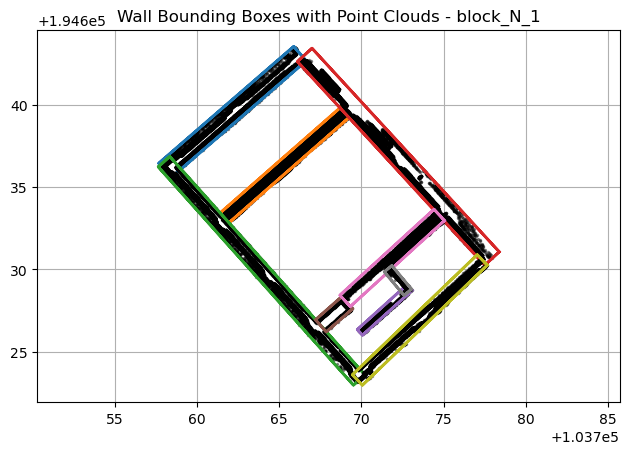

✅ Plotting wall data for: 'first_floor' (matched from 'first_floor')


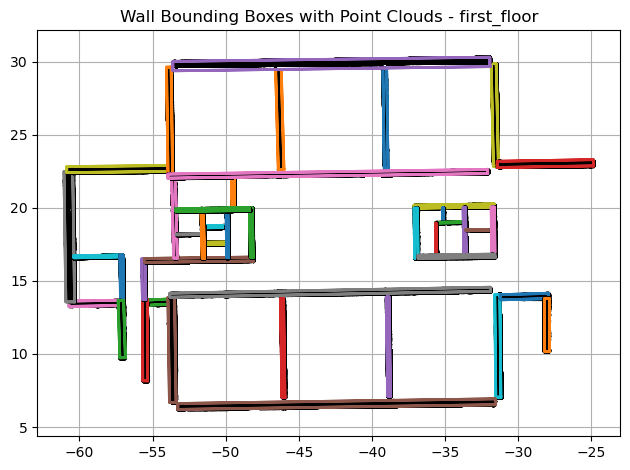

✅ Plotting wall data for: 'sc_1stwing' (matched from 'sc_1stwing')


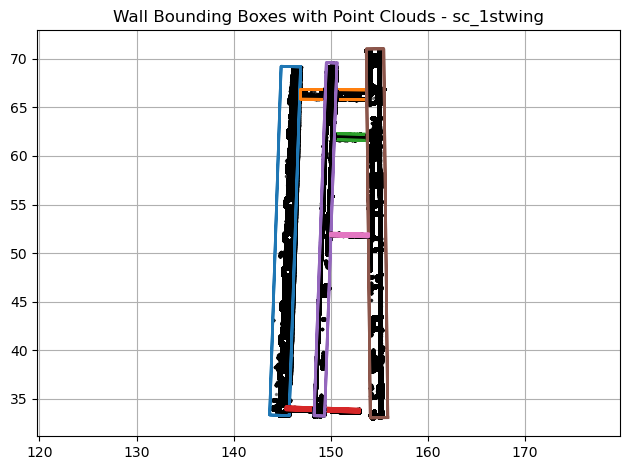

⚠️ No wall data available to plot for LAZ file: 'first_floor_cut'


In [15]:
check_bbox_lasz_overlap = True
already_plotted = False

if check_bbox_lasz_overlap and not already_plotted:

    for laz in laz_files:
        
        name = laz.stem.lower()

        # Try to find the closest matching key
        matching_keys = [k for k in wall_coords_dict if name in k.lower()]

        if matching_keys:
            key = matching_keys[0]  # Pick the first matching key
            print(f"✅ Plotting wall data for: '{key}' (matched from '{name}')")

            def plot_wall_bounding_boxes_debug(wall_coordinates, wall_vertices, name):
                import matplotlib.pyplot as plt
                for i, (points, bbox) in enumerate(zip(wall_coordinates, wall_vertices)):
                    ordered_bbox = np.vstack((bbox, bbox[0]))
                    plt.plot(points[:, 0], points[:, 1], 'k.', alpha=0.4, markersize=3,
                             label=f'Wall {i} points' if i == 0 else "")
                    plt.plot(ordered_bbox[:, 0], ordered_bbox[:, 1], linewidth=2,
                             label=f'Wall {i} bbox')
                plt.title(f"Wall Bounding Boxes with Point Clouds - {name}")
                plt.axis('equal')
                plt.grid(True)
                # plt.legend(fontsize=6, loc='center left', bbox_to_anchor=(1, 0.5))
                plt.tight_layout()
                plt.show()

            plot_wall_bounding_boxes_debug(
                wall_coords_dict[key],
                wall_bbox_vertices_dict.get(key, []),
                key
            )
            already_plotted = True
            # break  # Stop after one match
        else:
            print(f"⚠️ No wall data available to plot for LAZ file: '{name}'")


WALL SURFACES

In [16]:
from topologicpy.Topology import Topology
from topologicpy.Face import Face
from topologicpy.Wire import Wire
from topologicpy.Vertex import Vertex
from topologicpy.Shell import Shell  
from topologicpy.Topology import Topology


In [17]:
compute_surfaces_functions = True

if compute_surfaces_functions:

    def extract_faces(bbox):
       
        if len(bbox) != 8:
            raise ValueError("Expected 8 bounding box corners")
        
        return {
            "front":   np.array([bbox[0], bbox[1], bbox[5], bbox[4]]),
            "back":    np.array([bbox[3], bbox[2], bbox[6], bbox[7]]),
            "left":    np.array([bbox[0], bbox[3], bbox[7], bbox[4]]),
            "right":   np.array([bbox[1], bbox[2], bbox[6], bbox[5]]),
            "top":     np.array([bbox[4], bbox[5], bbox[6], bbox[7]]),
            "bottom":  np.array([bbox[0], bbox[1], bbox[2], bbox[3]])
        }


    def compute_oriented_bounding_box(laz_file_path):

        las_data = laspy.read(laz_file_path)
        
        x_coords = las_data.x
        y_coords = las_data.y
        z_coords = las_data.z

        points = np.vstack((x_coords, y_coords, z_coords)).T
        
        pca = PCA(n_components=3)
        pca.fit(points)
        
        rotation_matrix = pca.components_
        
        points_rotated = pca.transform(points)
        
        min_corner = np.min(points_rotated, axis=0)
        max_corner = np.max(points_rotated, axis=0)
        
        x_min, y_min, z_min = min_corner
        x_max, y_max, z_max = max_corner


        bbox_rotated = np.array([
            [x_min, y_min, z_min],  # Corner 0
            [x_max, y_min, z_min],  # Corner 1
            [x_max, y_max, z_min],  # Corner 2
            [x_min, y_max, z_min],  # Corner 3
            [x_min, y_min, z_max],  # Corner 4
            [x_max, y_min, z_max],  # Corner 5
            [x_max, y_max, z_max],  # Corner 6
            [x_min, y_max, z_max]   # Corner 7
        ])
        
        return points, points_rotated, bbox_rotated, rotation_matrix

    def extract_beta_angle_from_rotation_matrix(rotation_matrix):

        beta_rad = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
        beta_angle = np.degrees(beta_rad)
        
        return beta_angle

    def rotation_matrix_z(beta_angle):

        beta_rad = np.radians(beta_angle)
        rotation_matrix = np.array([
            [np.cos(beta_rad), -np.sin(beta_rad), 0],
            [np.sin(beta_rad), np.cos(beta_rad),  0],
            [0, 0, 1]
        ])
        
        return rotation_matrix

    def get_face_vertices(face):
        """Assumes face is already a list or ndarray of 3D vertices (from bbox)."""
        return np.array(face)

    def compute_wall_exterior_faces(all_base_vertices, all_top_vertices, offset=3):
        import open3d as o3d
        import numpy as np

        scene = o3d.t.geometry.RaycastingScene()
        exterior_results = []

        for i in range(len(all_base_vertices)):
            base = all_base_vertices[i]
            top = all_top_vertices[i]

            wall_faces = []
            wall_status = []

            for j in range(4):  # 4 vertical sides per wall
                v0 = base[j]
                v1 = base[(j + 1) % 4]
                v2 = top[(j + 1) % 4]
                v3 = top[j]

                vertices = np.array([v0, v1, v2, v3])
                triangles = np.array([[0, 1, 2], [2, 3, 0]])

                mesh = o3d.geometry.TriangleMesh()
                mesh.vertices = o3d.utility.Vector3dVector(vertices)
                mesh.triangles = o3d.utility.Vector3iVector(triangles)
                mesh.compute_triangle_normals()

                o3d_mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
                face_id = scene.add_triangles(o3d_mesh)

                wall_faces.append((vertices, face_id))

            # Now cast rays
            for vertices, face_id in wall_faces:
                center = np.mean(vertices, axis=0)
                v1 = vertices[1] - vertices[0]
                v2 = vertices[3] - vertices[0]
                normal = np.cross(v1, v2)
                normal = normal / np.linalg.norm(normal)

                ray_origin = center + normal * offset
                ray_direction = -normal
                ray = np.hstack((ray_origin, ray_direction))
                rays = o3d.core.Tensor(ray[np.newaxis, :], dtype=o3d.core.Dtype.Float32)

                hits = scene.cast_rays(rays)
                geometry_ids = hits['geometry_ids'].numpy()

                if len(geometry_ids) == 0 or geometry_ids[0] != face_id:
                    wall_status.append("exterior")
                else:
                    wall_status.append("interior")

            exterior_results.append(wall_status)

        return exterior_results



    def compute_centroids(faces):
        """Compute centroids for each face in a dictionary of faces."""
        centroids = {}
        for face_name, vertices in faces.items():
            centroids[face_name] = np.mean(vertices, axis=0).tolist()
        return centroids

    def extract_faces(bbox):
        """Extract faces from bounding box corners."""
        return {
            "front": [bbox[0], bbox[1], bbox[5], bbox[4]],  # Front face
            "back": [bbox[3], bbox[2], bbox[6], bbox[7]],   # Back face
            "left": [bbox[0], bbox[3], bbox[7], bbox[4]],   # Left face
            "right": [bbox[1], bbox[2], bbox[6], bbox[5]],  # Right face
            "top": [bbox[4], bbox[5], bbox[6], bbox[7]],    # Top face
            "bottom": [bbox[0], bbox[1], bbox[2], bbox[3]], # Bottom face
        }
    

    def create_topologic_face(surface_vertices):

        vertices = [Vertex.ByCoordinates(*v) for v in surface_vertices]
        wire = Wire.ByVertices(vertices + [vertices[0]])  # Close the wire
        face = Face.ByWire(wire)
        
        if face is None:
            print(f"Error: Failed to create face for vertices: {surface_vertices}")
        
        return face

    def check_face_edges(face):

        edges = Topology.Edges(face)
        edge_info = []

        for edge in edges:
            
            vertices = Topology.Vertices(edge)
            v1, v2 = vertices[0].Coordinates(), vertices[1].Coordinates()
            edge_info.append((v1, v2))
            print(f"Edge from {v1} to {v2}")

        return edge_info

    def check_face_connectivity(face1, face2):
    
        edges1 = set(check_face_edges(face1))
        edges2 = set(check_face_edges(face2))
        common_edges = edges1.intersection(edges2)
        if common_edges:
            print(f"Faces are connected with shared edges: {common_edges}")
        else:
            print("Faces are not connected. No shared edges found.")

        return common_edges

    def check_face_orientation(face):
    
        vertices = Topology.Vertices(face)
        if len(vertices) >= 3:
            v1, v2, v3 = vertices[0].Coordinates(), vertices[1].Coordinates(), vertices[2].Coordinates()
            normal = np.cross(np.array(v2) - np.array(v1), np.array(v3) - np.array(v1))
            print(f"Normal of the face: {normal}")
            return normal
        else:
            print("Face has fewer than 3 vertices.")
            
        return None

    def export_bounding_box_as_obj(walls_results, output_path, name="wall"):
        if not os.path.exists(output_path):
            os.makedirs(output_path, exist_ok=True)
        for i, wall in enumerate(walls_results):
            vertices = wall['vertices']
            faces = wall['faces']
            file_path = os.path.join(output_path, f"{name}_bbox_wall_{i}.obj")
            export_obj(vertices, faces, file_path)

    def export_obj(vertices, faces, file_name):
        """Exports vertices and faces to an OBJ file with correct indexing."""
        print(f"Attempting to export to: {file_name}")
        try:
            with open(file_name, 'w') as file:
                # Write all vertices
                for v in vertices:
                    file.write(f"v {v[0]} {v[1]} {v[2]}\n")

                # Write faces using vertex indices (OBJ format is 1-based)
                for face in faces:
                    indices = []
                    for fv in face:
                        match = np.where(np.all(np.isclose(vertices, fv), axis=1))[0]
                        if match.size > 0:
                            indices.append(match[0] + 1)  # OBJ is 1-indexed
                        else:
                            print(f"⚠️ Vertex not found in list: {fv}")

                    if len(indices) == 4:
                        file.write(f"f {indices[0]} {indices[1]} {indices[2]} {indices[3]}\n")
                    else:
                        print(f"⚠️ Could not resolve all vertex indices for face: {face}")

            print(f"✅ Exported OBJ file: {file_name}")
        except Exception as e:
            print(f"❌ Failed to export OBJ file: {file_name}, Error: {e}")



    def compute_features_surfaces(base_vertices, top_vertices, wall_idx=None):
        import numpy as np

        vertices = np.vstack([base_vertices, top_vertices])

        # Determine the longer and shorter edges to identify the wall's long axis
        edge_lengths = [
            np.linalg.norm(base_vertices[0] - base_vertices[1]),  # edge 0–1
            np.linalg.norm(base_vertices[1] - base_vertices[2])   # edge 1–2
        ]

        if edge_lengths[0] >= edge_lengths[1]:
            long_edge = (base_vertices[0], base_vertices[1])
            top_long_edge = (top_vertices[0], top_vertices[1])
            base_line_idx = [0, 1]
        else:
            long_edge = (base_vertices[1], base_vertices[2])
            top_long_edge = (top_vertices[1], top_vertices[2])
            base_line_idx = [1, 2]

        # Create surface vertices in counterclockwise order
        t1 = top_long_edge[0]
        t2 = top_long_edge[1]
        b2 = long_edge[1]
        b1 = long_edge[0]
        surface_vertices = [t1, t2, b2, b1]

        # Measurements
        length = np.linalg.norm(t1 - t2)
        height = np.linalg.norm(t1 - b1)
        area = length * height

        # Output dictionary
        surface_data = {
            "wall_id": wall_idx,
            "surface_vertices": [v.tolist() for v in surface_vertices],
            "base_line": {
                "id": f"wall_{wall_idx}_base",
                "start": b1.tolist(),
                "end": b2.tolist()
            },
            "top_line": {
                "id": f"wall_{wall_idx}_top",
                "start": t1.tolist(),
                "end": t2.tolist()
            },
            "length": length,
            "height": height,
            "area": area,
            "edges": [[v1.tolist(), v2.tolist()] for v1, v2 in zip(surface_vertices, surface_vertices[1:] + surface_vertices[:1])]
        }

        return surface_data


    def compute_features_surfaces(base_vertices, top_vertices, wall_idx=None):

        vertices = np.vstack([base_vertices, top_vertices])

        # Compute height
        z_base = np.mean(base_vertices[:, 2])
        z_top = np.mean(top_vertices[:, 2])
        height = abs(z_top - z_base)

        # Determine longer edge on base to define orientation
        edge_a = base_vertices[0] - base_vertices[1]
        edge_b = base_vertices[1] - base_vertices[2]
        len_a = np.linalg.norm(edge_a)
        len_b = np.linalg.norm(edge_b)

        if len_a >= len_b:
            idx_a, idx_b = 0, 1
        else:
            idx_a, idx_b = 1, 2

        # Base and top lines in longer direction
        base_start = base_vertices[idx_a]
        base_end = base_vertices[idx_b]
        top_start = top_vertices[idx_a]
        top_end = top_vertices[idx_b]

        # Compute center for surface
        center = (base_start + base_end + top_start + top_end) / 4.0

        # Direction and rotation (in XY)
        direction = top_end - top_start
        direction_xy = direction[:2]
        rotation_rad = np.arctan2(direction_xy[1], direction_xy[0])
        rotation_deg = np.degrees(rotation_rad)

        # Length along wall
        length = np.linalg.norm(top_end - top_start)

        # Create surface vertices (ccw)
        t1 = top_start
        t2 = top_end
        b2 = base_end
        b1 = base_start
        surface_vertices = [t1, t2, b2, b1]

        # Area of surface
        area = length * height

        # Format lines
        base_line = {
            "id": f"{wall_idx}_base" if wall_idx is not None else "base",
            "start": b1.tolist(),
            "end": b2.tolist()
        }
        top_line = {
            "id": f"{wall_idx}_top" if wall_idx is not None else "top",
            "start": t1.tolist(),
            "end": t2.tolist()
        }

        return {
            "wall_id": wall_idx,
            "surface_vertices": [v.tolist() for v in surface_vertices],
            "base_line": base_line,
            "top_line": top_line,
            "length": length,
            "height": height,
            "area": area,
            "rotation": rotation_deg
        }

    def export_surfaces_to_json(walls_results, output_json_path):
        
        """Exports surface geometry and features to JSON."""
        all_surfaces_data = []

        for i, wall in enumerate(walls_results):
            try:
                base_vertices = wall['vertices'][:4]
                top_vertices = wall['vertices'][4:]

                surface_data = compute_features_surfaces(
                    base_vertices=np.array(base_vertices),
                    top_vertices=np.array(top_vertices),
                    wall_idx=i
                )

                all_surfaces_data.append(surface_data)

            except KeyError as e:
                print(f"🔴 Missing key in wall data for wall {i+1}: {e}")
            except Exception as e:
                print(f"❌ Error processing wall {i+1} for surface export: {e}")

        # Final export
        try:
            with open(output_json_path, 'w') as json_file:
                json.dump(all_surfaces_data, json_file, indent=4)
            print(f"✅ All surfaces data exported to JSON: {output_json_path}")
        except Exception as e:
            print(f"❌ Failed to export surfaces to JSON. Error: {e}")


    def export_walls_to_json(all_walls_results, output_json_file):
        
        def convert(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            if isinstance(obj, np.generic):
                return obj.item()
            raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

        try:
            with open(output_json_file, 'w') as f:
                json.dump(all_walls_results, f, indent=4, default=convert)
            print(f"✅ Walls JSON exported: {output_json_file.name}")
        except Exception as e:
            print(f"❌ Failed to export wall JSON: {e}")


    def convert_to_list(data):
        """Recursively convert numpy arrays to lists for JSON compatibility."""
        if isinstance(data, np.ndarray):
            return data.tolist()
        elif isinstance(data, list):
            return [convert_to_list(item) for item in data]
        else:
            return data
        
    def extract_wall_surface_endpoints(json_data):
        points = []
        ids = []
        for wall in json_data:
            wall_id = wall['wall_id']
            base_start = wall['base_line']['start'][:2]
            base_end = wall['base_line']['end'][:2]
            points.append(np.array(base_start))
            ids.append((wall_id, "start"))
            points.append(np.array(base_end))
            ids.append((wall_id, "end"))
        return np.vstack(points), ids


    def compute_angle_between(v1, v2):
        unit_v1 = v1 / np.linalg.norm(v1)
        unit_v2 = v2 / np.linalg.norm(v2)
        dot_product = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
        return np.degrees(np.arccos(dot_product))


    def create_proximity_matrix(points, ids, threshold=2.0, angle_range=(70, 120)):
        num_walls = len(set(obj_id for obj_id, _ in ids))
        matrix = np.zeros((num_walls, num_walls), dtype=int)
        wall_vectors = {
            ids[i][0]: points[i + 1] - points[i]
            for i in range(0, len(points), 2)
        }
        dist_matrix = distance_matrix(points, points)
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                id_i, _ = ids[i]
                id_j, _ = ids[j]
                if id_i == id_j:
                    continue
                if dist_matrix[i, j] <= threshold:
                    angle = compute_angle_between(wall_vectors[id_i], wall_vectors[id_j])
                    if angle_range[0] <= angle <= angle_range[1]:
                        matrix[id_i][id_j] = 1
                        matrix[id_j][id_i] = 1
        return matrix


    def detect_intersections(proximity_matrix):
        wall_connections = {}
        for i in range(proximity_matrix.shape[0]):
            for j in range(i + 1, proximity_matrix.shape[1]):
                if proximity_matrix[i, j]:
                    wall_connections.setdefault(i, set()).add(j)
                    wall_connections.setdefault(j, set()).add(i)
        return wall_connections


    def group_connected_walls(wall_connections):
        visited, clusters = set(), []
        for wall in wall_connections:
            if wall not in visited:
                cluster = set()
                stack = [wall]
                while stack:
                    current = stack.pop()
                    if current not in visited:
                        visited.add(current)
                        cluster.add(current)
                        stack.extend(wall_connections.get(current, []))
                clusters.append(sorted(cluster))
        return clusters


    def export_wall_connectivity(connections, clusters, output_path):
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        data = {
            "wall_connections": {str(k): sorted(v) for k, v in connections.items()},
            "wall_clusters": clusters
        }
        with open(output_path, 'w') as f:
            json.dump(data, f, indent=4)
        print(f"✅ Exported wall connectivity to: {output_path}")


    def export_detailed_wall_graph(walls_data, connections, clusters, output_path):
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        graph = {
            "walls": [],
            "connections": {str(k): sorted(v) for k, v in connections.items()},
            "clusters": clusters
        }
        for wall in walls_data:
            graph["walls"].append({
                "id": wall["wall_id"],
                "base_line": wall["base_line"],
                "top_line": wall["top_line"],
                "center": np.mean(wall["surface_vertices"], axis=0).tolist(),
                "rotation": wall["rotation"],
                "area": wall["area"],
                "length": wall["length"],
                "height": wall["height"],
                "surface_vertices": wall["surface_vertices"]
            })
        with open(output_path, 'w') as f:
            json.dump(graph, f, indent=4)
        print(f"✅ Exported detailed wall graph to: {output_path}")

    def to_topologic_face(vertices):
        try:
            from topologicpy.Face import Face
            from topologicpy.Vertex import Vertex
            from topologicpy.Wire import Wire

            verts = [Vertex.ByCoordinates(*v) for v in vertices]
            wire = Wire.ByVertices(verts + [verts[0]])  # Close the wire!
            return Face.ByWire(wire)

        except Exception as e:
            print("⚠️ Error creating face:", e)
            return None
    
    def rotate_points_2d(points, center, rotation_matrix):
        rotated_points = []

        for point in points:
            shifted = point - center
            rotated = np.dot(rotation_matrix, shifted)  # Apply to column vector
            rotated_points.append(rotated + center)

        return np.array(rotated_points)
    
    def extract_sorted_wall_bboxes(wall_coordinates):
        all_wall_bbox_vertices = []
        rotation_matrices = []

        for wall_points in wall_coordinates:
            coords_2d = wall_points[:, :2]
            bbox, rot_matrix = compute_bounding_box(coords_2d)

            # Apply rotation to get the transformed box
            center = np.mean(bbox, axis=0)
            rotated_bbox = rotate_points_2d(bbox, center, rot_matrix)
            sorted_bbox = sort_counterclockwise(rotated_bbox)

            all_wall_bbox_vertices.append(sorted_bbox)
            rotation_matrices.append(rot_matrix)

        return all_wall_bbox_vertices, rotation_matrices


In [18]:
import json
import numpy as np
from pathlib import Path

compute_exterior_faces = True

if compute_exterior_faces:

    laz_files = list(data_base.glob('**/*.laz'))
    missing_files = []

    for laz_file in laz_files:
    
        name = laz_file.stem.lower()
        print(f"\n🔎 Processing: {name}")

        walls_results_folder = Path(
            rf"C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\{name}\json")
        
        if not walls_results_folder.exists():
            print(f"❌ Folder not found: {walls_results_folder}")
            missing_files.append(name)
            continue

        wall_json_files = list(walls_results_folder.glob("*.json"))
        print(f"🗂️ Found {len(wall_json_files)} wall result files.")

        all_walls_results = {}
        for result_file in wall_json_files:
            try:
                key = result_file.stem
                with open(result_file) as f:
                    walls_data = json.load(f)
                all_walls_results[key] = walls_data
            except Exception as e:
                print(f"❌ Failed to load {result_file}: {e}")

        print("📦 Available keys:", list(all_walls_results.keys()))

        def normalize_name(s):
            return s.lower().replace("_", "")

        # Try to match the wall result key regardless of case/underscores
        target_key = normalize_name(name + "_walls")

        matched_key = next(
            (k for k in all_walls_results.keys() if normalize_name(k) == target_key),
            None
        )

        if matched_key:
            print(f"✅ Matched wall results key: {matched_key}")
            walls_results_raw = all_walls_results[matched_key]
        else:
            print(f"❌ No wall results found for: {name}")
            missing_files.append(name)
            continue

        faces = []
        face_metadata = []

        for i, wall in enumerate(walls_results):
            if isinstance(wall, str):
                print(f"⚠️ Skipping invalid wall {i}: wall is a string.")
                continue

            try:
                top_center_lines = wall.get("top_center_lines", [])
                base_center_lines = wall.get("base_center_lines", [])

                if len(top_center_lines) != 2 or len(base_center_lines) != 2:
                    print(f"⚠️ Wall {i} has invalid center lines.")
                    continue

                t1v, t2v = np.array(top_center_lines[0]), np.array(top_center_lines[1])
                b1v, b2v = np.array(base_center_lines[0]), np.array(base_center_lines[1])
                surface_vertices = [t1v, t2v, b2v, b1v]

                face = create_topologic_face(surface_vertices)
                if face:
                    print(f"✅ Face {i + 1} created.")
                    check_face_edges(face)
                    check_face_orientation(face)
                else:
                    print(f"❌ Could not create face for wall {i + 1}")
            except Exception as e:
                print(f"❌ Error at wall {i}: {e}")

        try:
            print(f"\n--- Computing exterior status for: {name} ---")
            laz, _, _, _ = kul.load_point_cloud(laz_file)
            matching_ttl = find_matching_ttl(name, input_folder_ttl)

            levels_data = load_levels(laz, matching_ttl)
            wall_coords, _, _ = object_points(laz, matching_ttl)
            all_wall_bbox_vertices, rotation_matrices = extract_sorted_wall_bboxes(wall_coords)

            all_base_vertices, all_top_vertices, _ = compute_3d_features(
                laz, wall_coords, all_wall_bbox_vertices, rotation_matrices,
                matching_ttl, levels_data.get('floor_bboxes', []), levels_data.get('ceiling_bboxes', [])
            )

            for wall_idx, (base, top) in enumerate(zip(all_base_vertices, all_top_vertices)):
                for side_idx in range(4):
                    try:
                        v0 = base[side_idx]
                        v1 = base[(side_idx + 1) % 4]
                        v2 = top[(side_idx + 1) % 4]
                        v3 = top[side_idx]
                        face_vertices = [v0, v1, v2, v3]

                        face = to_topologic_face(face_vertices)
                        if face:
                            normal = np.cross(np.array(v1) - v0, np.array(v3) - v0)
                            normal /= np.linalg.norm(normal)
                            faces.append(face)
                            face_metadata.append({
                                "wall_id": wall_idx,
                                "side_id": side_idx,
                                "vertices": [v0.tolist(), v1.tolist(), v2.tolist(), v3.tolist()],
                                "normal": normal.tolist()
                            })
                        else:
                            print(f"❌ Face gen failed (wall {wall_idx}, side {side_idx})")
                    except Exception as e:
                        print(f"❌ Error (wall {wall_idx}, side {side_idx}): {e}")

            print(f"\n📊 Created {len(faces)} side faces.")
            print(f"📋 Metadata entries: {len(face_metadata)}")

            if face_metadata:
                print("🧪 Sample metadata:\n", json.dumps(face_metadata[0], indent=2))
                exterior_status = compute_wall_exterior_faces(face_metadata, all_top_vertices, offset=3)

                print(f"\n🌐 Exterior face status for '{name}':")
                for wall_idx, results in enumerate(exterior_status):
                    print(f"Wall {wall_idx}:")
                    for face_idx, status in enumerate(results):
                        print(f"  → Side {face_idx}: {status}")

                output_path = Path("outputs") / f"{name}_face_metadata.json"
                output_path.parent.mkdir(exist_ok=True, parents=True)
                with open(output_path, "w") as f:
                    json.dump(face_metadata, f, indent=2)
                print(f"📁 Saved metadata to: {output_path}")

        except Exception as e:
            print(f"❌ Error during exterior face prep for {name}: {e}")

    if missing_files:
        print("\n⚠️ Missing wall results for:")
        for mf in missing_files:
            print(f" - {mf}")
        print(f"Total: {len(missing_files)}")
    else:
        print("\n✅ All files processed with wall results.")



🔎 Processing: 01
🗂️ Found 1 wall result files.
📦 Available keys: ['01_openings']
❌ No wall results found for: 01

🔎 Processing: 01a
🗂️ Found 4 wall result files.
📦 Available keys: ['01a_openings', '01a_walls', '01a_walls_centerline_surfaces', '01a_walls_surfaces']
✅ Matched wall results key: 01a_walls
✅ Face 1 created.
Edge from (146.89052925330213, 69.1648540581426, 5.353) to (145.7153021784717, 33.272053311474764, 5.353)
Edge from (145.7153021784717, 33.272053311474764, 5.353) to (145.7153021784717, 33.272053311474764, 1.0070000000000001)
Edge from (145.7153021784717, 33.272053311474764, 1.0070000000000001) to (146.89052925330213, 69.1648540581426, 1.0070000000000001)
Edge from (146.89052925330213, 69.1648540581426, 1.0070000000000001) to (146.89052925330213, 69.1648540581426, 5.353)
Normal of the face: [155.99011205  -5.10753687   0.        ]
✅ Face 2 created.
Edge from (153.71203481143982, 66.80035343570569, 5.353) to (153.7042814338401, 65.79134491634966, 5.353)
Edge from (153.70

In [19]:
from sklearn.decomposition import PCA
import numpy as np
from collections import defaultdict
import os
import json
import glob


directory = fr"C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\{name}\json"
output_json_root = fr"C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\{name}\json"

centerline_surface_computation = True

if centerline_surface_computation:

    surface_json_paths = glob.glob(os.path.join(directory, "**", "*_walls_surfaces.json"), recursive=True)

    if not surface_json_paths:
        print("⚠️ No matching *_walls_surfaces.json files found.")
    
    os.makedirs(output_json_root, exist_ok=True)

    for surface_json_path in surface_json_paths:
        base_name = os.path.basename(surface_json_path)
        name_without_extension = base_name.replace("_walls_surfaces.json", "")

        print(f"\n🔎 Processing: {name_without_extension}")

        with open(surface_json_path, "r") as f:
            try:
                face_metadata = json.load(f)
                if not isinstance(face_metadata, list) or not all('wall_id' in face and 'vertices' in face for face in face_metadata):
                    print(f"❌ Skipping {surface_json_path}: Invalid JSON structure.")
                    continue
            except json.JSONDecodeError as e:
                print(f"❌ Failed to parse JSON for {surface_json_path}: {e}")
                continue

        centerline_faces = []
        centerline_metadata = []

        wall_faces = defaultdict(list)
        for face in face_metadata:
            wall_faces[face['wall_id']].extend(face['vertices'])

        print(f"🧱 Walls detected: {len(wall_faces)}")

        skipped = []

        for i, (wall_id, verts) in enumerate(wall_faces.items()):
            try:
                verts_np = np.array(verts)
                xy = verts_np[:, :2]
                z = verts_np[:, 2]

                pca = PCA(n_components=1)
                pca.fit(xy)
                direction = pca.components_[0]
                center = np.mean(xy, axis=0)

                projections = xy @ direction
                p1_xy = center + direction * np.min(projections - projections.mean())
                p2_xy = center + direction * np.max(projections - projections.mean())

                z_base = np.min(z)
                z_top = np.max(z)

                v1 = np.array([*p1_xy, z_base])
                v2 = np.array([*p2_xy, z_base])
                v3 = np.array([*p2_xy, z_top])
                v4 = np.array([*p1_xy, z_top])
                quad = [v1, v2, v3, v4]

                centerline_faces.append(quad)
                centerline_metadata.append({
                    "wall_id": wall_id,
                    "vertices": [v.tolist() for v in quad],
                    "type": "centerline"
                })

                print(f"✅ Wall {wall_id} ({i+1}/{len(wall_faces)}): Centerline face extracted.")
            except Exception as e:
                skipped.append((wall_id, str(e)))
                print(f"❌ Wall {wall_id} failed: {e}")

        print(f"\n📊 Final centerline surfaces computed: {len(centerline_faces)}")
        print(f"📦 Collected {len(centerline_metadata)} face(s)")

        if skipped:
            print(f"⚠️ Skipped {len(skipped)} wall(s):")
            for wall_id, err in skipped:
                print(f"  - Wall {wall_id}: {err}")

        # Save output
        output_json_path = os.path.join(output_json_root, f"{name_without_extension}_walls_centerline_surfaces.json")
        try:
            with open(output_json_path, "w") as f:
                json.dump(centerline_metadata, f, indent=2)
            print(f"✅ Exported JSON: {output_json_path}")
        except Exception as e:
            print(f"❌ Failed to save JSON: {e}")
            


🔎 Processing: 01b
🧱 Walls detected: 7
✅ Wall 0 (1/7): Centerline face extracted.
✅ Wall 1 (2/7): Centerline face extracted.
✅ Wall 2 (3/7): Centerline face extracted.
✅ Wall 3 (4/7): Centerline face extracted.
✅ Wall 4 (5/7): Centerline face extracted.
✅ Wall 5 (6/7): Centerline face extracted.
✅ Wall 6 (7/7): Centerline face extracted.

📊 Final centerline surfaces computed: 7
📦 Collected 7 face(s)
✅ Exported JSON: C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\first_floor_cut\json\01b_walls_centerline_surfaces.json

🔎 Processing: 01
🧱 Walls detected: 13
✅ Wall 0 (1/13): Centerline face extracted.
✅ Wall 1 (2/13): Centerline face extracted.
✅ Wall 2 (3/13): Centerline face extracted.
✅ Wall 3 (4/13): Centerline face extracted.
✅ Wall 4 (5/13): Centerline face extracted.
✅ Wall 5 (6/13): Centerline face extracted.
✅ Wall 6 (7/13): Centerline face extracted.
✅ Wall 7 (8/13): Centerline face extracted.
✅ Wall 8 (9/13): Centerline face extracted.
✅ Wall

EXPORT HRML FOR VISUALISATION



In [20]:
export_html_plotly = True

if export_html_plotly:

    import os
    import glob
    import json
    import numpy as np
    import plotly.graph_objects as go
    import matplotlib.pyplot as plt

    root_dir = r'C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts'
    cmap = plt.get_cmap("tab20", 20)
    json_paths = glob.glob(os.path.join(root_dir, '**', '*_walls_centerline_surfaces.json'), recursive=True)

    if not json_paths:
        print("⚠️ No JSON files found.")
    else:
        for json_path in json_paths:
            try:
                with open(json_path, 'r') as f:
                    centerline_metadata = json.load(f)
            except json.JSONDecodeError as e:
                print(f"❌ Skipping {json_path}: JSON error: {e}")
                continue

            filename = os.path.basename(json_path)
            name = filename.replace("_walls_centerline_surfaces.json", "")
            output_dir = os.path.dirname(json_path)

            print(f"📊 Plotting: {name}")

            fig = go.Figure()

            for face in centerline_metadata:
                if face.get("type") != "centerline":
                    continue

                vertices = np.array(face["vertices"])
                wall_id = face["wall_id"]
                r, g, b = cmap(wall_id % 20)[:3]
                color = f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.7)'

                triangles = [[0, 1, 2], [0, 2, 3]]
                for tri in triangles:
                    tri_coords = vertices[tri]
                    fig.add_trace(go.Mesh3d(
                        x=tri_coords[:, 0],
                        y=tri_coords[:, 1],
                        z=tri_coords[:, 2],
                        i=[0], j=[1], k=[2],
                        color=color,
                        opacity=0.7,
                        hovertemplate=f"Wall ID: {wall_id}<extra></extra>",
                        showscale=False
                    ))

            fig.update_layout(
                title=f"Centerline Surfaces: {name}",
                scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z',
                    aspectmode='data'
                ),
                margin=dict(l=0, r=0, b=0, t=40),
                showlegend=False
            )

            output_html_path = os.path.join(output_dir, f"{name}_centerline_plot.html")
            fig.write_html(output_html_path)
            print(f"✅ Saved plot: {output_html_path}")


📊 Plotting: 01a
✅ Saved plot: C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\01a\json\01a_centerline_plot.html
📊 Plotting: 01b
✅ Saved plot: C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\01b\json\01b_centerline_plot.html
📊 Plotting: 08_ShortOffice_01_F1_small_pred
✅ Saved plot: C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\08_ShortOffice_01_F1_small_pred\json\08_ShortOffice_01_F1_small_pred_centerline_plot.html
📊 Plotting: 08_ShortOffice_01_F2_small_pred
✅ Saved plot: C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\08_ShortOffice_01_F2_small_pred\json\08_ShortOffice_01_F2_small_pred_centerline_plot.html
📊 Plotting: block_N_1
✅ Saved plot: C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\block_N_1\json\block_N_1_centerline_plot.html
📊 Plotting: 08_ShortOffice_01_F1_small_pred
✅ Saved plot: C:\Users\oscar\OneDri

🔍 Found 1 files.


📂 Processing: house_01__walls_centerline_surfaces.json
✅ Extracted base lines for 7 wall(s).
🔧 Snapped 0 endpoint pairs.
🔗 Shared wall relationships: 5


C:\Users\oscar\AppData\Local\Temp\ipykernel_9436\80047313.py:128: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



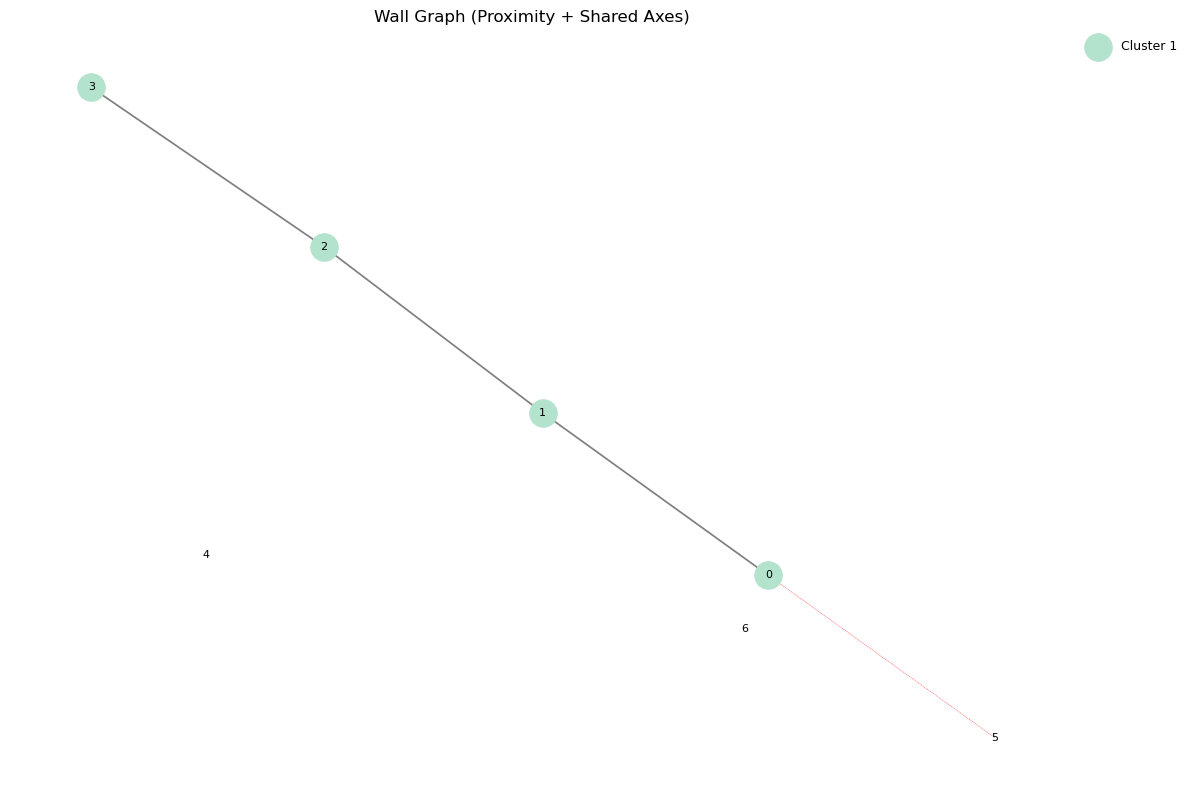

In [21]:
plot_wall_graph = True

if plot_wall_graph:
    
    import numpy as np
    import networkx as nx
    import matplotlib.pyplot as plt
    from collections import defaultdict
    from scipy.spatial import distance_matrix
    import matplotlib.cm as cm
    import json

    def convert_face_metadata_to_base_lines(face_metadata):
        wall_faces = defaultdict(list)
        for face in face_metadata:
            try:
                wall_id = face["wall_id"]
                vertices = face["vertices"]
                if len(vertices) != 4:
                    continue
                z_avg = np.mean([v[2] for v in vertices])
                wall_faces[wall_id].append((z_avg, vertices))
            except Exception as e:
                print(f"⚠️ Skipping malformed face: {e}")
        result = []
        for wall_id, faces in wall_faces.items():
            base_face = sorted(faces, key=lambda x: x[0])[0][1]
            result.append({
                "wall_id": wall_id,
                "base_line": {
                    "start": base_face[3],
                    "end": base_face[2]
                }
            })
        print(f"✅ Extracted base lines for {len(result)} wall(s).")
        return result

    # --- Geometry and angle checks ---
    def extract_wall_surface_endpoints(base_lines):
        points, ids = [], []
        for wall in base_lines:
            wall_id = wall["wall_id"]
            start = wall["base_line"]["start"][:2]
            end = wall["base_line"]["end"][:2]
            points.extend([np.array(start), np.array(end)])
            ids.extend([(wall_id, "start"), (wall_id, "end")])
        return np.vstack(points), ids

    def compute_angle_between(v1, v2):
        unit_v1 = v1 / np.linalg.norm(v1)
        unit_v2 = v2 / np.linalg.norm(v2)
        dot = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
        return np.degrees(np.arccos(dot))

    # --- Proximity and connectivity ---
    def create_proximity_matrix(points, ids, threshold=2.0, angle_range=(0, 180)):
        wall_vectors = defaultdict(list)
        for i in range(0, len(points), 2):
            wall_id = ids[i][0]
            wall_vectors[wall_id].append(points[i + 1] - points[i])
        wall_ids = sorted(set(i[0] for i in ids))
        matrix = np.zeros((max(wall_ids) + 1, max(wall_ids) + 1), dtype=int)
        dist = distance_matrix(points, points)
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                id_i, _ = ids[i]
                id_j, _ = ids[j]
                if id_i == id_j:
                    continue
                if dist[i, j] <= threshold:
                    for v1 in wall_vectors[id_i]:
                        for v2 in wall_vectors[id_j]:
                            angle = compute_angle_between(v1, v2)
                            if angle_range[0] <= angle <= angle_range[1]:
                                matrix[id_i][id_j] = matrix[id_j][id_i] = 1
                                break
        return matrix

    def detect_intersections(matrix):
        connections = {}
        for i in range(matrix.shape[0]):
            for j in range(i + 1, matrix.shape[1]):
                if matrix[i, j]:
                    connections.setdefault(i, set()).add(j)
                    connections.setdefault(j, set()).add(i)
        return connections

    def group_connected_walls(connections):
        visited, clusters = set(), []
        for wall in connections:
            if wall not in visited:
                stack, cluster = [wall], set()
                while stack:
                    current = stack.pop()
                    if current not in visited:
                        visited.add(current)
                        cluster.add(current)
                        stack.extend(connections.get(current, []))
                clusters.append(sorted(cluster))
        return clusters

    def plot_wall_graph_with_shared(base_lines, connections, shared_connections, clusters=None):
        import matplotlib.pyplot as plt
        import networkx as nx
        import matplotlib.cm as cm
        from collections import defaultdict

        G = nx.Graph()
        for wall in base_lines:
            G.add_node(wall["wall_id"])

        for wall_id, neighbors in connections.items():
            for neighbor in neighbors:
                G.add_edge(wall_id, neighbor, type='proximity')

        for wall_id, neighbors in shared_connections.items():
            for neighbor in neighbors:
                if not G.has_edge(wall_id, neighbor):
                    G.add_edge(wall_id, neighbor, type='shared')

        pos = nx.kamada_kawai_layout(G)

        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_title("Wall Graph (Proximity + Shared Axes)", fontsize=12, pad=5)

        # Nodes
        if clusters:
            cmap = cm.get_cmap("Pastel2", len(clusters))
            for i, cluster in enumerate(clusters):
                nx.draw_networkx_nodes(
                    G, pos,
                    nodelist=cluster,
                    node_color=[cmap(i)],
                    linewidths=0.5,
                    node_size=400,
                    label=f"Cluster {i+1}"
                )
        else:
            nx.draw_networkx_nodes(
                G, pos,
                node_color="lightgray",
                node_size=550
            )

        edge_styles = defaultdict(list)
        for u, v, data in G.edges(data=True):
            edge_styles[data['type']].append((u, v))

        if 'proximity' in edge_styles:
            nx.draw_networkx_edges(
                G, pos,
                edgelist=edge_styles['proximity'],
                width=1.25,
                alpha=0.5,
                edge_color="black",
            )

        if 'shared' in edge_styles:
            nx.draw_networkx_edges(
                G, pos,
                edgelist=edge_styles['shared'],
                width=0.25,
                alpha=1,
                edge_color="red",
                style='dashed'
            )

        # Labels
        nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

        ax.axis("off")
        if clusters:
            ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=9, frameon=False)
        else:
            ax.legend(["Proximity", "Shared Axis"], loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=9)

        plt.tight_layout()
    plt.show()



    # --- Endpoint snapping ---
    def snap_connected_wall_endpoints(base_lines, connections, threshold=0.3):
        wall_dict = {wall["wall_id"]: wall for wall in base_lines}
        endpoint_updates = {}
        for wall_a, neighbors in connections.items():
            for wall_b in neighbors:
                if wall_a >= wall_b:
                    continue
                a_line = wall_dict[wall_a]["base_line"]
                b_line = wall_dict[wall_b]["base_line"]
                for key_a, pt_a in a_line.items():
                    for key_b, pt_b in b_line.items():
                        pt_a_np = np.array(pt_a[:2])
                        pt_b_np = np.array(pt_b[:2])
                        if np.linalg.norm(pt_a_np - pt_b_np) <= threshold:
                            midpoint = ((pt_a_np + pt_b_np) / 2).tolist()
                            z_a = pt_a[2] if len(pt_a) == 3 else 0.0
                            z_b = pt_b[2] if len(pt_b) == 3 else 0.0
                            avg_z = (z_a + z_b) / 2
                            updated_point = midpoint + [avg_z]
                            endpoint_updates[(wall_a, key_a)] = updated_point
                            endpoint_updates[(wall_b, key_b)] = updated_point
        for (wall_id, key), value in endpoint_updates.items():
            wall_dict[wall_id]["base_line"][key] = value
        print(f"🔧 Snapped {len(endpoint_updates)//2} endpoint pairs.")
        return list(wall_dict.values())

    # --- Shared wall relationship detection ---
    def point_to_line_distance(point, line_start, line_end):
        point = np.array(point[:2])
        line_start = np.array(line_start[:2])
        line_end = np.array(line_end[:2])
        line_vec = line_end - line_start
        point_vec = point - line_start
        proj_len = np.dot(point_vec, line_vec) / np.linalg.norm(line_vec)
        proj_point = line_start + proj_len * (line_vec / np.linalg.norm(line_vec))
        return np.linalg.norm(point - proj_point)

    def are_axis_and_point_close(line1, point2, max_distance=1.0):
        return point_to_line_distance(point2, line1[0], line1[1]) < max_distance

    def find_shared_wall_relationships(base_lines, max_distance=0.5):
        shared_connections = {}
        for i, wall_a in enumerate(base_lines):
            id_a = wall_a["wall_id"]
            axis_a = [wall_a["base_line"]["start"], wall_a["base_line"]["end"]]
            for j, wall_b in enumerate(base_lines):
                id_b = wall_b["wall_id"]
                if id_a >= id_b:
                    continue
                b_start = wall_b["base_line"]["start"]
                b_end = wall_b["base_line"]["end"]
                if are_axis_and_point_close(axis_a, b_start, max_distance) or \
                are_axis_and_point_close(axis_a, b_end, max_distance):
                    shared_connections.setdefault(id_a, set()).add(id_b)
                    shared_connections.setdefault(id_b, set()).add(id_a)
        print(f"🔗 Shared wall relationships: {len(shared_connections)}")
        return shared_connections


    def process_wall_face_metadata(face_metadata, threshold=1.0, angle_range=(0, 180), snap_threshold=0.2, do_plot=True):
        base_lines = convert_face_metadata_to_base_lines(face_metadata)
        
        if not base_lines:
            print("⚠️ No valid walls extracted from face metadata. Skipping...")
            return None  # Stop early!

        points, ids = extract_wall_surface_endpoints(base_lines)
        matrix = create_proximity_matrix(points, ids, threshold=threshold, angle_range=angle_range)
        connections = detect_intersections(matrix)
        clusters = group_connected_walls(connections)
        snapped_base_lines = snap_connected_wall_endpoints(base_lines, connections, threshold=snap_threshold)
        shared_connections = find_shared_wall_relationships(snapped_base_lines)

        if do_plot:
            plot_wall_graph_with_shared(
                snapped_base_lines,
                connections,
                shared_connections,
                clusters
            )

        return {
            "base_lines": snapped_base_lines,
            "connections": connections,
            "clusters": clusters,
            "shared_connections": shared_connections
        }


    import json
    import os
    import glob
    import numpy as np

    input_dir = fr"C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts\{name}\json"
    json_files = glob.glob(os.path.join(input_dir, "*_walls_centerline_surfaces.json"))

    if not json_files:
        print("⚠️ No matching files found.")
    else:
        print(f"🔍 Found {len(json_files)} files.\n")

        for json_path in json_files:
            print(f"\n📂 Processing: {os.path.basename(json_path)}")

            try:
                with open(json_path, "r") as f:
                    face_metadata = json.load(f)
            except Exception as e:
                print(f"❌ Failed to load JSON: {e}")
                continue

            if not isinstance(face_metadata, list):
                print("⚠️ Invalid format. Expected a list of faces.")
                continue

            # Process and plot
            result = process_wall_face_metadata(
                face_metadata,
                threshold=1.0,
                angle_range=(0, 180),
                snap_threshold=0.2,
                do_plot=True
            )
            if result is None:
                print("🚫 Skipping due to empty or invalid wall data.")
    

COLUMNS

In [22]:
column_computation_def = True

if column_computation_def:

    from rdflib import Graph
    from pathlib import Path
    import numpy as np

    def column_points(laz, graph_path):
        # Ensure graph path is parsed correctly as a local file
        graph_uri = Path(graph_path).as_uri()
        graph = Graph().parse(graph_uri)
        
        # Parse nodes
        nodes = tl.graph_to_nodes(graph)
        columns_nodes = [column for column in nodes if 'columns' in column.subject.lower() and isinstance(column, PointCloudNode)]
        print(f"📌 Number of column nodes found: {len(columns_nodes)}")

        column_coordinates = []
        idx_list = []

        for column in columns_nodes:
            idx = np.where((laz.classes == column.class_id) & (laz.objects == column.object_id))

            if idx and len(idx[0]) > 0:
                coords = np.vstack((laz.x[idx], laz.y[idx], laz.z[idx])).T
                column_coordinates.append(coords)
                idx_list.append(idx)
            else:
                print(f"⚠️ No matching points found for column: {column.subject}")

        return column_coordinates, columns_nodes, idx_list
    
    def plot_column_points(column_coordinates):
        
        fig = go.Figure()

        # Iterate through each column's coordinates
        for i, coordinates in enumerate(column_coordinates):
            x, y, z = coordinates[:, 0], coordinates[:, 1], coordinates[:, 2]

            # Add each column's points as a separate trace
            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='markers',
                marker=dict(size=2),
                name=f'Column {i + 1}'
            ))

        # Set plot layout with specified aspect ratio
        fig.update_layout(
            title="3D Scatter Plot of Column Points",
            scene=dict(
                xaxis_title="X",
                yaxis_title="Y",
                zaxis_title="Z",
                aspectmode="manual",
                aspectratio=dict(x=1, y=1, z=0.3)
            ),
            showlegend=True
        )

        fig.show()

    def column_bounding_boxes(laz, column_coordinates, columns_nodes):

        column_coordinates_ = []
        column_oriented_bboxes = []

        for column in columns_nodes:
            
            idx = np.where((laz.classes == column.class_id) & (laz.objects == column.object_id))

            if idx is not None and len(idx[0]) > 0: 
                coord_x_col = laz.x[idx]
                coord_y_col = laz.y[idx]
                coord_z_col = laz.z[idx]

                coordinates_col = np.vstack((coord_x_col, coord_y_col, coord_z_col)).T
                column_coordinates_.append(coordinates_col)

                # 1. Create an oriented bounding box for the column
                point_cloud_col = o3d.geometry.PointCloud()  # Assuming open3d for point cloud manipulation
                point_cloud_col.points = o3d.utility.Vector3dVector(coordinates_col)

                oriented_bounding_box_col = point_cloud_col.get_oriented_bounding_box()
                column_oriented_bboxes.append(oriented_bounding_box_col)

                # 2. Compute the dominant plane using RANSAC
                plane_model_col, inliers_col = point_cloud_col.segment_plane(distance_threshold=0.03,
                                                                    ransac_n=3,
                                                                    num_iterations=1000)

                # 3. Compute the 2D normal of the column (normal vector from plane equation)
                normal_col = plane_model_col[:3]  # Extracting the normal vector from the plane model
                normal_col[2] = 0  # Set the z-component to zero for 2D normal
                normal_col /= np.linalg.norm(normal_col)  # Normalize the vector

                # 4. Determine the direction of the column
                box_center_col = np.asarray(oriented_bounding_box_col.get_center())
                face_center_col = point_cloud_col.select_by_index(inliers_col).get_center()
                face_center_col[2] = box_center_col[2]  # Align face center's height with the bounding box center

                sign_col = np.sign(np.dot(normal_col, face_center_col - box_center_col))  # Use dot product to determine direction

                # If sign is negative, flip the normal
                normal_col *= -1 if sign_col == -1 else 1

                # Output the result for debugging
                print(f'Column {column.object_id}:')
                print(f' - Oriented Bounding Box Center: {box_center_col}')
                print(f' - Plane Model: {plane_model_col}')
                print(f' - 2D Normal: {normal_col}')

        return column_coordinates, column_oriented_bboxes, columns_nodes
    
    def column_features(column_points, bbox, rotation_matrix):
        """
        Computes the width, depth, height, center, and rotation of a column.
        
        Parameters:
        - column_points: 3D coordinates of the column points (Nx3 array).
        - bbox: The bounding box (4x2 array for 2D x, y coordinates).
        - rotation_matrix: 2x2 rotation matrix.
        
        Returns:
        - width: Width of the column based on bounding box.
        - depth: Depth of the column based on bounding box.
        - height: Height based on the z-coordinates of column_points.
        - center: Center point of the bounding box.
        - rotation: Rotation angle in degrees.
        """
        
        # Ensure bbox has at least 4 corners for width and depth calculation
        if bbox.shape[0] < 4:
            print("Invalid bounding box shape.")
            return None
        
        # Width and Depth from bounding box (distances between consecutive corners)
        A, B, C, D = bbox[:4]
        width = np.linalg.norm(B - A)
        depth = np.linalg.norm(C - B)
        
        # Calculate height using z-coordinates of the column points
        z_coords = column_points[:, 2]
        height = np.ptp(z_coords)  # peak-to-peak (max - min) along the z-axis
        
        # Center as the mean of bounding box points
        center = np.mean(bbox, axis=0)
        
        # Calculate rotation from the rotation matrix (assumes 2D rotation matrix)
        rotation = np.degrees(np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0]))
        
        return width, depth, height, center, rotation

    def compute_rotation_matrix_using_pca(points):
        pca = PCA(n_components=2)
        pca.fit(points)
        rotation_matrix = pca.components_.T  # Transpose to get correct orientation
        return rotation_matrix

    def rotate_points_2d(points, center, rotation_matrix):
        points = np.asarray(points)
        centered = points - center
        rotated = np.dot(centered, rotation_matrix)
        return rotated + center


    def compute_column_bounding_box(points):
        pi2 = np.pi / 2.0
        hull_points = points[ConvexHull(points).vertices]
        
        # Calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)
        
        # Create rotation matrices for each unique angle
        rotations = []
        for angle in angles:
            rotation = np.array([
                [np.cos(angle), -np.sin(angle)],
                [np.sin(angle), np.cos(angle)]
            ])
            rotations.append(rotation)
        
        min_area = float('inf')
        best_box = None
        best_rotation = None
        
        # Find the best bounding box by applying each rotation
        for rotation in rotations:
            rotated = np.dot(hull_points, rotation.T)
            min_x, max_x = np.min(rotated[:, 0]), np.max(rotated[:, 0])
            min_y, max_y = np.min(rotated[:, 1]), np.max(rotated[:, 1])
            area = (max_x - min_x) * (max_y - min_y)
            
            if area < min_area:
                min_area = area
                best_rotation = rotation
                best_box = np.array([
                    np.dot([max_x, min_y], best_rotation),
                    np.dot([min_x, min_y], best_rotation),
                    np.dot([min_x, max_y], best_rotation),
                    np.dot([max_x, max_y], best_rotation)
                ])
        
        return best_box, best_rotation


In [23]:
column_computation = True

if column_computation:
    
    data_base = Path.cwd().parents[0] / 'data'
    laz_files = list(data_base.glob('**/*.las')) + list(data_base.glob('**/*.laz'))
    ttl_files = list(input_folder_ttl.glob("*.ttl"))

    unmatched_ttls = []

    for ttl_file in ttl_files:
        print(f"\n🔄 Processing: {ttl_file.name}")

        base_stem = ttl_file.stem.replace("_graph", "")
        laz_match = next((l for l in laz_files if base_stem in l.stem), None)

        if not laz_match:
            print(f"⚠️ No matching LAS/LAZ file for {ttl_file.name}")
            unmatched_ttls.append(ttl_file.name)
            continue

        print(f"✅ Found matching LAS/LAZ: {laz_match.name}")
        laz = laspy.read(laz_match)

        graph = Graph().parse(ttl_file.as_uri())
        nodes = tl.graph_to_nodes(graph)
        columns_nodes = [n for n in nodes if 'columns' in n.subject.lower() and isinstance(n, PointCloudNode)]

        if not columns_nodes:
            print("⚠️ No column nodes found in TTL.")
            continue

        column_coordinates, columns_nodes, idx_column_list = column_points(laz, ttl_file)

        all_rotated_column_boxes = []
        rotations = []

        for i, col_pts in enumerate(column_coordinates):
            points_2d = col_pts[:, :2]
            z_vals = col_pts[:, 2]
            center = np.mean(points_2d, axis=0)
            center_z = np.mean(z_vals)
            center_3d = np.append(center, center_z)

            rotation_matrix = compute_rotation_matrix_using_pca(points_2d)
            bbox_2d, rotation_matrix_column = compute_column_bounding_box(points_2d)
            rotated_box_2d = rotate_points_2d(bbox_2d, center, rotation_matrix.T)
            rotated_box_3d = np.column_stack((rotated_box_2d, np.full(rotated_box_2d.shape[0], center_z)))

            rotations.append(rotation_matrix_column)
            all_rotated_column_boxes.append(rotated_box_3d)

        os.makedirs(geometry_output_columns_bbox_path, exist_ok=True)
        columns_data = []

        for i, coords in enumerate(column_coordinates):
            bbox = all_rotated_column_boxes[i]
            rotation_matrix = rotations[i]

            features = column_features(coords, bbox, rotation_matrix)
            if not features:
                continue

            width, depth, height, center, rotation = features
            center_3d = np.array(center) if len(center) == 3 else np.append(center, np.mean(coords[:, 2]))

            columns_data.append({
                "column_id": i,
                "width": width,
                "depth": depth,
                "height": height,
                "center": center_3d.tolist(),
                "rotation": rotation
            })

            vertices = [
                [bbox[0][0], bbox[0][1], center_3d[2] - height / 2],
                [bbox[1][0], bbox[1][1], center_3d[2] - height / 2],
                [bbox[2][0], bbox[2][1], center_3d[2] - height / 2],
                [bbox[3][0], bbox[3][1], center_3d[2] - height / 2],
                [bbox[0][0], bbox[0][1], center_3d[2] + height / 2],
                [bbox[1][0], bbox[1][1], center_3d[2] + height / 2],
                [bbox[2][0], bbox[2][1], center_3d[2] + height / 2],
                [bbox[3][0], bbox[3][1], center_3d[2] + height / 2],
            ]

            faces = [
                [1, 2, 3, 4],
                [5, 6, 7, 8],
                [1, 2, 6, 5],
                [2, 3, 7, 6],
                [3, 4, 8, 7],
                [4, 1, 5, 8]
            ]

            obj_filename = geometry_output_columns_bbox_path / f"{ttl_file.stem}_column_{i}.obj"
            with open(obj_filename, "w") as f:
                for v in vertices:
                    f.write(f"v {v[0]} {v[1]} {v[2]}\n")
                for face in faces:
                    f.write("f " + " ".join([str(idx) for idx in face]) + "\n")
            print(f"✅ Exported OBJ: {obj_filename}")


            output_json_root = Path(output_json_root)
            ttl_file = Path(ttl_file)

            json_path = output_json_root / ttl_file.stem / f"{ttl_file.stem}_columns.json"
            json_path.parent.mkdir(parents=True, exist_ok=True)

            with open(json_path, "w") as json_file:
                json.dump(columns_data, json_file, indent=4)
                print(f"📄 Exported column features to: {json_path}")

        if unmatched_ttls:
            print("\n📭 The following TTLs had no matching LAS/LAZ files:")
            for name in unmatched_ttls:
                print(f" - {name}")
 


🔄 Processing: 01a_graph.ttl
✅ Found matching LAS/LAZ: 01a.laz
⚠️ No column nodes found in TTL.

🔄 Processing: 01b_graph.ttl
✅ Found matching LAS/LAZ: 01b.laz
⚠️ No column nodes found in TTL.

🔄 Processing: 01_graph.ttl
✅ Found matching LAS/LAZ: 01.laz
⚠️ No column nodes found in TTL.

🔄 Processing: block_N_1_graph.ttl
✅ Found matching LAS/LAZ: block_N_1.laz
⚠️ No column nodes found in TTL.

🔄 Processing: block_N_2_graph.ttl
✅ Found matching LAS/LAZ: block_N_2.laz
⚠️ No column nodes found in TTL.

🔄 Processing: block_N_3b_graph.ttl
✅ Found matching LAS/LAZ: block_N_3b.laz
⚠️ No column nodes found in TTL.

🔄 Processing: block_N_3_graph.ttl
✅ Found matching LAS/LAZ: block_N_3.laz
⚠️ No column nodes found in TTL.

🔄 Processing: block_N_4_graph.ttl
✅ Found matching LAS/LAZ: block_N_4.laz
⚠️ No column nodes found in TTL.

🔄 Processing: first_floor_graph.ttl
✅ Found matching LAS/LAZ: first_floor.laz
📌 Number of column nodes found: 16
✅ Exported OBJ: c:\Users\oscar\OneDrive - Fondazione Bruno

OPENINGS

In [24]:
density_threshold = 1
downsampling_factor = 500

In [25]:
openings_computation_def = True

if openings_computation_def:

    from sklearn.decomposition import PCA
    from sklearn.neighbors import KernelDensity

    def windows_doors_points(laz, graph_path):

        graph = Graph().parse(str(graph_path))
        nodes = tl.graph_to_nodes(graph)

        doors_nodes = [node for node in nodes if 'doors' in node.subject.lower() and isinstance(node, PointCloudNode)]
        windows_nodes = [node for node in nodes if 'windows' in node.subject.lower() and isinstance(node, PointCloudNode)]

        print(f'Number of door nodes: {len(doors_nodes)}')
        print(f'Number of window nodes: {len(windows_nodes)}')

        doors_coordinates = []
        windows_coordinates = []
        idx_list_doors = []  
        idx_list_windows = []  

        for door in doors_nodes:
            idx_doors = np.where((laz.classes == door.class_id) & (laz.objects == door.object_id))

            if idx_doors is not None and len(idx_doors[0]) > 0:
                coord_x = laz.x[idx_doors]
                coord_y = laz.y[idx_doors]
                coord_z = laz.z[idx_doors]


                coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
                doors_coordinates.append(coordinates_)  # Store the door coordinates

                idx_list_doors.append(idx_doors)

        for window in windows_nodes:
    
            idx_windows = np.where((laz.classes == window.class_id) & (laz.objects == window.object_id))

            if idx_windows is not None and len(idx_windows[0]) > 0:
                coord_x = laz.x[idx_windows]
                coord_y = laz.y[idx_windows]
                coord_z = laz.z[idx_windows]

                coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
                windows_coordinates.append(coordinates_)  # Store the window coordinates

                idx_list_windows.append(idx_windows)

        return doors_coordinates, windows_coordinates, idx_list_doors, idx_list_windows

    def object_door_points(laz, graph_path):

        graph = Graph().parse(str(graph_path))
        nodes = tl.graph_to_nodes(graph)

        # Filter wall nodes
        doors_nodes = [door for door in nodes if 'doors' in door.subject.lower() and isinstance(door, PointCloudNode)]
        print(f'Number of door nodes: {len(doors_nodes)}')

        door_coordinates = []
        idx_list = []  # List to store indices

        for door in doors_nodes:
            
            idx = np.where((laz.classes == door.class_id) & (laz.objects == door.object_id))

            if idx is not None and len(idx[0]) > 0:  # Ensure valid and non-empty indices
                coord_x = laz.x[idx]
                coord_y = laz.y[idx]
                coord_z = laz.z[idx]

                coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
                door_coordinates.append(coordinates_)  # Store the coordinates

                # Store the index for the wall
                idx_list.append(idx)

        return door_coordinates, doors_nodes, idx_list  

    def object_window_points(laz, graph_path):

        graph = Graph().parse(str(graph_path))
        nodes = tl.graph_to_nodes(graph)

        # Filter wall nodes
        windows_nodes = [window for window in nodes if 'windows' in window.subject.lower() and isinstance(window, PointCloudNode)]
        print(f'Number of windows nodes: {len(windows_nodes)}')

        window_coordinates = []
        idx_list = []  # List to store indices

        for window in windows_nodes:
            
            idx = np.where((laz.classes == window.class_id) & (laz.objects == window.object_id))

            if idx is not None and len(idx[0]) > 0:  # Ensure valid and non-empty indices
                coord_x = laz.x[idx]
                coord_y = laz.y[idx]
                coord_z = laz.z[idx]

                coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
                window_coordinates.append(coordinates_)  # Store the coordinates

                # Store the index for the wall
                idx_list.append(idx)

        return window_coordinates, windows_nodes, idx_list  

    def bounding_door_boxes(doors_coords_down, doors_nodes):
        """
        Computes oriented bounding boxes for door nodes based on downsampled coordinates.

        Parameters:
        - doors_coords_down: np.ndarray, shape (N, 3), all downsampled door points (concatenated)
        - doors_nodes: list of door node objects, each with a .resource.points attribute

        Returns:
        - doors_coordinates: list of np.ndarray, one per door
        - door_oriented_bboxes: list of open3d.geometry.OrientedBoundingBox
        - doors_nodes: unchanged
        """
        doors_coordinates = []
        door_oriented_bboxes = []

        offset = 0
        for door in doors_nodes:
            n_points = door.resource.points.shape[0]
            coords = doors_coords_down[offset:offset + n_points]
            offset += n_points

            if coords.shape[0] == 0:
                continue

            doors_coordinates.append(coords)

            point_cloud = o3d.geometry.PointCloud()
            point_cloud.points = o3d.utility.Vector3dVector(coords)

            oriented_bounding_box = point_cloud.get_oriented_bounding_box()
            door_oriented_bboxes.append(oriented_bounding_box)

            # Optional: plane fitting & orientation (if still needed)
            try:
                plane_model, inliers = point_cloud.segment_plane(
                    distance_threshold=0.01, ransac_n=3, num_iterations=1000)

                normal = plane_model[:3]
                normal[2] = 0
                normal /= np.linalg.norm(normal)

                box_center = np.asarray(oriented_bounding_box.get_center())
                inlier_cloud = point_cloud.select_by_index(inliers)
                face_center = np.mean(np.asarray(inlier_cloud.points), axis=0)
                face_center[2] = box_center[2]

                sign = np.sign(np.dot(normal, face_center - box_center))
                if sign == -1:
                    normal *= -1

                print(f'Door {door.object_id}:')
                print(f' - Oriented Bounding Box Center: {box_center}')
                print(f' - Plane Model: {plane_model}')
                print(f' - 2D Normal: {normal}')
                print(f' - Door Direction: {"outwards" if sign == 1 else "inwards"}')

            except:
                print(f"⚠️ Could not compute plane for door {door.object_id}")

        return doors_coordinates, door_oriented_bboxes, doors_nodes


    def bounding_window_boxes(laz, windows_coordinates, windows_nodes):

        windows_coordinates = []
        window_oriented_bboxes = []

        for window in windows_nodes:
            
            idx = np.where((laz.classes == window.class_id) & (laz.objects == window.object_id))

            if idx is not None and len(idx[0]) > 0:  
                
                coord_x = laz.x[idx]
                coord_y = laz.y[idx]
                coord_z = laz.z[idx]

                coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
                windows_coordinates.append(coordinates_)

                # 1. Create an oriented bounding box for the wall
                point_cloud = o3d.geometry.PointCloud()  # Assuming open3d for point cloud manipulation
                point_cloud.points = o3d.utility.Vector3dVector(coordinates_)

                oriented_bounding_box = point_cloud.get_oriented_bounding_box()
                window_oriented_bboxes.append(oriented_bounding_box)

                # 2. Compute the dominant plane using RANSAC
                plane_model, inliers = point_cloud.segment_plane(distance_threshold=0.01,
                                                                    ransac_n=3,
                                                                    num_iterations=1000)

                # 3. Compute the 2D normal of the wall (normal vector from plane equation)
                normal = plane_model[:3]  # Extracting the normal vector from the plane model
                normal[2] = 0  # Set the z-component to zero for 2D normal
                normal /= np.linalg.norm(normal)  # Normalize the vector

                # 4. Determine the direction of the wall
                box_center = np.asarray(oriented_bounding_box.get_center())
                face_center = point_cloud.select_by_index(inliers).get_center()
                face_center[2] = box_center[2]  # Align face center's height with the bounding box center

                sign = np.sign(np.dot(normal, face_center - box_center))  # Use dot product to determine direction

                # If sign is negative, flip the normal
                normal *= -1 if sign == -1 else 1

                # Output the result for debugging
                print(f'Window {window.object_id}:')
                print(f' - Oriented Bounding Box Center: {box_center}')
                print(f' - Plane Model: {plane_model}')
                print(f' - 2D Normal: {normal}')
                print(f' - Window Direction: {"outwards" if sign == 1 else "inwards"}')

        return windows_coordinates, window_oriented_bboxes, windows_nodes

    def clean_open_door_points(door_coords, density_threshold = density_threshold, bandwidth=0.1):
        """
        Optimized: PCA and density-based filtering to clean door coordinates.

        Parameters:
            door_coords (np.array): Nx3 NumPy array.
            density_threshold (float): Density threshold to keep points.
            bandwidth (float): Bandwidth for KDE.

        Returns:
            np.array: Filtered door coordinates.
        """
        if door_coords.size == 0:
            return door_coords  # Return early if no valid points

        xy_coords = door_coords[:, :2]  # Use only XY plane
        pca = PCA(n_components=2)
        pca.fit(xy_coords)
        shortest_axis = pca.components_[1]  # Second PCA component (short axis)

        projected = np.dot(xy_coords, shortest_axis)  # Project onto short axis

        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        kde.fit(projected.reshape(-1, 1))
        density = np.exp(kde.score_samples(projected.reshape(-1, 1)))

        mask = density > density_threshold  # Keep high-density points
        return door_coords[mask]

    def preprocess_nested_coordinates(coordinates):
        """
        Flattens and filters a nested list of coordinates to ensure all elements are valid 3D points.
        Args:
            coordinates (list): List of arrays or lists containing coordinates.

        Returns:
            np.ndarray: A cleaned array of valid 3D points.
        """
        valid_points = []
        for coord in coordinates:
            try:
                # Attempt to flatten and filter the coordinate data
                array = np.array(coord)
                if len(array.shape) == 2 and array.shape[1] == 3:  # Valid array of shape (N, 3)
                    valid_points.extend(array)  # Add all rows to the valid points
                elif len(array.shape) == 1 and array.shape[0] == 3:  # Valid single 3D point
                    valid_points.append(array)
                else:
                    print(f"Skipping invalid coordinate: {coord}")
            except Exception as e:
                print(f"Error processing coordinate {coord}: {e}")
        return np.array(valid_points)
    
        
    def simplify_bounding_box_with_individual_z(bbox):
        """
        Simplifies an Open3D OrientedBoundingBox to 4 base and 4 top vertices,
        ensuring alignment, counterclockwise order, and individual z_min/z_max.

        Parameters:
            bbox (OrientedBoundingBox): The bounding box to simplify.

        Returns:
            np.array: Simplified vertices (8 vertices: 4 base, 4 top).
        """
        points = np.asarray(bbox.get_box_points())
        z_min = points[:, 2].min()  # Individual z_min for this box
        z_max = points[:, 2].max()  # Individual z_max for this box

        base_vertices = points[np.argsort(points[:, 2])[:4], :2]  # Extract XY of lowest 4 points
        top_vertices = points[np.argsort(points[:, 2])[:4], :2]   # Use the same XY for top

        # Order vertices counterclockwise in the XY-plane
        def order_ccw(vertices):
            center = vertices.mean(axis=0)
            angles = np.arctan2(vertices[:, 1] - center[1], vertices[:, 0] - center[0])
            return vertices[np.argsort(angles)]

        base_vertices = order_ccw(base_vertices)
        top_vertices = order_ccw(top_vertices)

        # Combine with individual z_min and z_max
        base_vertices = np.hstack((base_vertices, np.full((4, 1), z_min)))
        top_vertices = np.hstack((top_vertices, np.full((4, 1), z_max)))

        return np.vstack((base_vertices, top_vertices))

    def plot_combined_bboxes_with_individual_z(
        door_coords, door_bboxes, window_coords, window_bboxes, 
        title="Doors and Windows",
        title_font_size=20,
        axis_label_font_size=12,
        tick_font_size=10,
        background_color = "rgb(245, 245,245)",
        grid_color="white",
        x_range=None,
        y_range=None,
        z_range=None
    ):
        """
        Plots doors and windows with simplified bounding boxes in a single plot.
        Each bounding box has its individual z_min and z_max.
        Doors are blue; windows are red.
        """
        fig = go.Figure()


        for coord in door_coords:
            fig.add_trace(go.Scatter3d(
                x=[coord[0]], y=[coord[1]], z=[coord[2]],
                mode='markers',
                marker=dict(size=5, color='blue'),
                name='Door Center'
            ))

        for bbox in door_bboxes:
            vertices = simplify_bounding_box_with_individual_z(bbox)
            for i in range(4):
                fig.add_trace(go.Scatter3d(
                    x=[vertices[i][0], vertices[(i + 1) % 4][0]],
                    y=[vertices[i][1], vertices[(i + 1) % 4][1]],
                    z=[vertices[i][2], vertices[(i + 1) % 4][2]],
                    mode='lines',
                    line=dict(color='blue', width=2),
                    showlegend=False
                ))
                fig.add_trace(go.Scatter3d(
                    x=[vertices[i][0], vertices[i + 4][0]],
                    y=[vertices[i][1], vertices[i + 4][1]],
                    z=[vertices[i][2], vertices[i + 4][2]],
                    mode='lines',
                    line=dict(color='blue', width=2),
                    showlegend=False
                ))
                fig.add_trace(go.Scatter3d(
                    x=[vertices[i + 4][0], vertices[(i + 1) % 4 + 4][0]],
                    y=[vertices[i + 4][1], vertices[(i + 1) % 4 + 4][1]],
                    z=[vertices[i + 4][2], vertices[(i + 1) % 4 + 4][2]],
                    mode='lines',
                    line=dict(color='blue', width=2),
                    showlegend=False
                ))

        # Plot window centers and bounding boxes (red)
        for coord in window_coords:
            fig.add_trace(go.Scatter3d(
                x=[coord[0]], y=[coord[1]], z=[coord[2]],
                mode='markers',
                marker=dict(size=5, color='red'),
                name='Window Center'
            ))

        for bbox in window_bboxes:
            vertices = simplify_bounding_box_with_individual_z(bbox)
            for i in range(4):
                fig.add_trace(go.Scatter3d(
                    x=[vertices[i][0], vertices[(i + 1) % 4][0]],
                    y=[vertices[i][1], vertices[(i + 1) % 4][1]],
                    z=[vertices[i][2], vertices[(i + 1) % 4][2]],
                    mode='lines',
                    line=dict(color='red', width=2),
                    showlegend=False
                ))
                fig.add_trace(go.Scatter3d(
                    x=[vertices[i][0], vertices[i + 4][0]],
                    y=[vertices[i][1], vertices[i + 4][1]],
                    z=[vertices[i][2], vertices[i + 4][2]],
                    mode='lines',
                    line=dict(color='red', width=2),
                    showlegend=False
                ))
                fig.add_trace(go.Scatter3d(
                    x=[vertices[i + 4][0], vertices[(i + 1) % 4 + 4][0]],
                    y=[vertices[i + 4][1], vertices[(i + 1) % 4 + 4][1]],
                    z=[vertices[i + 4][2], vertices[(i + 1) % 4 + 4][2]],
                    mode='lines',
                    line=dict(color='red', width=2),
                    showlegend=False
                ))


        fig.update_layout(
            title=dict(
                text=title,
                font=dict(size=title_font_size),
                x=0.5  # Center the title
            ),
            scene=dict(
                xaxis=dict(
                    title=dict(text='x axis', font=dict(size=axis_label_font_size)),
                    range=x_range,
                    tickfont=dict(size=tick_font_size),
                    backgroundcolor=background_color,
                    gridcolor=grid_color,
                    showbackground=True
                ),
                yaxis=dict(
                    title=dict(text='y axis', font=dict(size=axis_label_font_size)),
                    range=y_range,
                    tickfont=dict(size=tick_font_size),
                    backgroundcolor=background_color,
                    gridcolor=grid_color,
                    showbackground=True
                ),
                zaxis=dict(
                    title=dict(text='z axis', font=dict(size=axis_label_font_size)),
                    range=z_range,
                    tickfont=dict(size=tick_font_size),
                    backgroundcolor=background_color,
                    gridcolor=grid_color,
                    showbackground=True
                ),
                aspectratio=dict(x=1, y=1, z=0.1)
            ),
            width=800,
            height=800
        )

        fig.show()

    def extract_vertices_from_bboxes(bboxes):
        all_vertices_dict = {}
        for key, bbox in enumerate(bboxes):
            if isinstance(bbox, o3d.geometry.OrientedBoundingBox):
                vertices = np.asarray(bbox.get_box_points())
                if vertices.shape == (8, 3):
                    all_vertices_dict[key] = vertices
                else:
                    print(f"Invalid bbox shape for key {key}, expected (8, 3) but got {vertices.shape}")
        return all_vertices_dict
    

    def preprocess_nested_coordinates(coordinates):
        """
        Flattens and filters a nested list of coordinates to ensure all elements are valid 3D points.
        """
        valid_points = []
        for coord in coordinates:
            try:
                array = np.array(coord)
                if array.ndim == 2 and array.shape[1] == 3:
                    valid_points.extend(array)
                elif array.ndim == 1 and array.shape[0] == 3:
                    valid_points.append(array)
                else:
                    print(f"Skipping invalid coordinate: {coord}")
            except Exception as e:
                print(f"Error processing coordinate {coord}: {e}")
        return np.array(valid_points)

    def preprocess_coordinates(coordinates):
        """
        Flattens and filters a nested list of coordinates to ensure all elements are valid 3D points.

        Args:
            coordinates (list): List of arrays or lists containing coordinates. It may include nested lists or invalid data.

        Returns:
            np.ndarray: A cleaned array of valid 3D points with shape (N, 3), where N is the number of valid points.
        """
        valid_points = []
        
        for coord in coordinates:
            try:
 
                array = np.array(coord)
                
                if array.ndim == 2 and array.shape[1] == 3:
                    valid_points.extend(array) 
                
                elif array.ndim == 1 and array.shape[0] == 3:
                    valid_points.append(array)
                
                else:
                    print(f"Skipping invalid coordinate: {coord}")
            
            except Exception as e:
                print(f"Error processing coordinate {coord}: {e}")

        return np.array(valid_points)

    def group_coordinates_by_bounding_boxes(opening_coordinates, rotated_opening_boxes):
        """
        Groups coordinates into separate arrays for each bounding box.
        """
        grouped_coords = []
        for i, bbox in enumerate(rotated_opening_boxes):
            bbox_points = np.asarray(bbox.get_box_points())
            min_bounds = bbox_points.min(axis=0)
            max_bounds = bbox_points.max(axis=0)
            in_bbox = (
                (opening_coordinates[:, 0] >= min_bounds[0]) & (opening_coordinates[:, 0] <= max_bounds[0]) &
                (opening_coordinates[:, 1] >= min_bounds[1]) & (opening_coordinates[:, 1] <= max_bounds[1]) &
                (opening_coordinates[:, 2] >= min_bounds[2]) & (opening_coordinates[:, 2] <= max_bounds[2])
            )
            grouped_coords.append(opening_coordinates[in_bbox])
        
        return grouped_coords

    def compute_3d_opertures_features(opening_coordinates, rotated_opening_boxes):
        from shapely.geometry import Polygon
        import numpy as np

        all_opening_base_vertices = []
        all_opening_top_vertices = []
        opening_properties = []

        for i, opening_points in enumerate(opening_coordinates):
            if opening_points.size == 0:
                print(f"⚠️ No points found for bounding box {i}. Skipping.")
                continue

            z_vals = opening_points[:, 2]
            z_min, z_max = np.min(z_vals), np.max(z_vals)
            height = z_max - z_min

            box = rotated_opening_boxes[i]
            box_points = np.asarray(box.get_box_points())  # 8 points

            # Compute center
            center = np.mean(box_points, axis=0)

            # Project to 2D for ordering
            base_2d = box_points[:4, :2]
            base_3d = box_points[:4]

            # Order in counterclockwise using shapely
            poly = Polygon(base_2d)
            if not poly.exterior.is_ccw:
                base_3d = base_3d[::-1]  # Reverse to ensure CCW

            # Create top vertices at z_max with same XY
            top_3d = base_3d.copy()
            top_3d = base_3d.copy()  # No translation, keep base_3d as is


            # Get rotation axes from 2 base vectors
            vec1 = base_3d[1] - base_3d[0]
            vec2 = base_3d[3] - base_3d[0]
            x_axis = vec1 / np.linalg.norm(vec1)
            y_axis = vec2 / np.linalg.norm(vec2)
            rotation_matrix = np.array([x_axis[:2], y_axis[:2]])  # Only XY rotation

            thickness = np.min([np.linalg.norm(vec1), np.linalg.norm(vec2)])
            length = np.max([np.linalg.norm(vec1), np.linalg.norm(vec2)])

            all_opening_base_vertices.append(base_3d)
            all_opening_top_vertices.append(top_3d)

            opening_properties.append({
                'Opening id': i,
                'bbox_vertices': np.vstack((base_3d, top_3d)),
                'center': center,
                'rotation_matrix': rotation_matrix,
                'length': length,
                'thickness': thickness,
                'height': height
            })

        return all_opening_base_vertices, all_opening_top_vertices, opening_properties



    import json
    import numpy as np

    def convert_ndarray_to_list(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, list):
            return [convert_ndarray_to_list(i) for i in obj]
        elif isinstance(obj, dict):
            return {k: convert_ndarray_to_list(v) for k, v in obj.items()}
        else:
            return obj

    def save_openings_to_json(door_data, window_data, file_path):
        # Convert all NumPy arrays to lists
        door_data_clean = convert_ndarray_to_list(door_data)
        window_data_clean = convert_ndarray_to_list(window_data)

        openings_data = {
            "openings": {
                "doors": door_data_clean,
                "windows": window_data_clean
            }
        }

        with open(file_path, 'w') as json_file:
            json.dump(openings_data, json_file, indent=4)

        print(f"JSON data saved to: {file_path}")

    def save_openings_to_obj(vertices, faces, file_path):
        """
        Saves the vertices and faces of an opening in .obj format.
        """
        with open(file_path, 'w') as file:
            for vertex in vertices:
                file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
            for face in faces:
                indices = [str(i + 1) for i in face]
                file.write(f"f {' '.join(indices)}\n")
        print(f"OBJ data saved to: {file_path}")
        

In [26]:
print(laz.classes)
print(laz.objects)

[2 2 2 ... 4 4 4]
[3. 3. 3. ... 5. 5. 5.]


In [27]:
computation_openings = True

if computation_openings:

    from dataclasses import dataclass
    from typing import List, Dict

    data_base = Path.cwd().parents[0] / 'data'
    laz_files = list(data_base.glob('**/*.las')) + list(data_base.glob('**/*.laz'))

    output_json_root = Path(output_json_root)

    def preprocess_coordinates(coords):
        # Example preprocessing: center the points and normalize
        if coords.shape[0] == 0:
            return coords
        mean = np.mean(coords, axis=0)
        centered = coords - mean
        return centered
    
    def compute_tight_bbox(points: np.ndarray):
        if len(points) == 0:
            return None

        min_corner = np.min(points, axis=0)
        max_corner = np.max(points, axis=0)
        return [min_corner, max_corner]


    def bounding_door_boxes(coords, nodes):
        bboxes = []
        grouped_coords = []

        for node in nodes:
            if getattr(node, 'resource', None) is not None:
                points = node.resource.points
                bbox = compute_tight_bbox(points)
                if bbox:
                    bboxes.append(bbox)
                    grouped_coords.append(points.tolist())
                else:
                    bboxes.append([np.zeros(3), np.zeros(3)])
                    grouped_coords.append([])
        return coords, bboxes, grouped_coords


    def bounding_window_boxes(laz, coords, nodes):
        bboxes = []
        grouped_coords = []

        for node in nodes:
            if getattr(node, 'resource', None) is not None:
                points = node.resource.points
                bbox = compute_tight_bbox(points)
                if bbox:
                    bboxes.append(bbox)
                    grouped_coords.append(points.tolist())
                else:
                    bboxes.append([np.zeros(3), np.zeros(3)])
                    grouped_coords.append([])
        return coords, bboxes, grouped_coords


    import numpy as np

    import numpy as np

    def compute_3d_opertures_features(grouped_points, bboxes):
        base_vertices = []
        top_vertices = []
        props_list = []

        for points, bbox in zip(grouped_points, bboxes):
            points = np.array(points)
            if points.shape[0] < 3:
                # Not enough points to compute features
                base_vertices.append(bbox)
                top_vertices.append(bbox)
                props_list.append({
                    "center": np.mean(bbox, axis=0),
                    "height": 0.0,
                    "thickness": 0.0,
                    "length": 0.0,
                    "rotation_matrix": np.eye(3)
                })
                continue

            min_pt = np.min(points, axis=0)
            max_pt = np.max(points, axis=0)
            center = np.mean(points, axis=0)
            height = max_pt[2] - min_pt[2]
            thickness = max_pt[1] - min_pt[1]
            length = max_pt[0] - min_pt[0]

            base_vertices.append([min_pt, max_pt])
            top_vertices.append([min_pt, max_pt])

            props = {
                "center": center,
                "height": height,
                "thickness": thickness,
                "length": length,
                "rotation_matrix": np.eye(3),  # Identity for placeholder
            }

            props_list.append(props)

        return base_vertices, top_vertices, props_list

    def group_coordinates_by_bounding_boxes(coords, bboxes):
        grouped = [[] for _ in bboxes]

        for point in coords:
            for i, bbox in enumerate(bboxes):
                min_corner = np.minimum(bbox[0], bbox[1])
                max_corner = np.maximum(bbox[0], bbox[1])

                if np.all(point >= min_corner) and np.all(point <= max_corner):
                    grouped[i].append(point)
                    break  # Assign each point to only one group

        return grouped

    def classify_nodes_by_class(nodes):
        """Fallback classifier using both class_name and class_id."""
        groups = {
            'doors': [],
            'windows': [],
        }
        for node in nodes:
            class_name = getattr(node, "class_name", "").lower()
            class_id = getattr(node, "class_id", None)

            if "door" in class_name or class_id == 4:
                groups['doors'].append(node)
            elif "window" in class_name or class_id == 3:
                groups['windows'].append(node)
        return groups

    for ttl_file in input_folder_ttl.glob("*.ttl"):
        
        print(f"\n🔄 Processing: {ttl_file.name}")
        base_stem = ttl_file.stem.replace("_graph", "")
        laz_match = next((l for l in laz_files if base_stem in l.stem), None)

        if not laz_match:
            print(f"⚠️ No matching LAS/LAZ file for {ttl_file.name}")
            continue

        try:
            laz, _, _, _ = kul.load_point_cloud(laz_match)
            print("🎯 Available class IDs:", np.unique(laz.classes))
            print("🎯 Available object IDs:", np.unique(laz.objects))
        except Exception as e:
            print(f"❌ Could not load point cloud: {e}")
            continue

        # from rdflib import Graph
        # from geomapi.nodes.pointcloudnode import PointCloudNode

        # def save_boxes_as_obj(boxes, filename):
        #     import open3d as o3d

        #     geometries = []
        #     for box in boxes:
        #         min_corner = np.min(box, axis=0)
        #         max_corner = np.max(box, axis=0)
        #         mesh_box = o3d.geometry.TriangleMesh.create_box(
        #             width=max_corner[0] - min_corner[0],
        #             height=max_corner[1] - min_corner[1],
        #             depth=max_corner[2] - min_corner[2]
        #         )
        #         mesh_box.translate(min_corner)
        #         geometries.append(mesh_box)

        #     # Combine all boxes
        #     all_mesh = geometries[0]
        #     for mesh in geometries[1:]:
        #         all_mesh += mesh

        #     o3d.io.write_triangle_mesh(str(filename), all_mesh)
        

        def save_boxes_as_obj(boxes, filename):
            from pathlib import Path

            filename = Path(filename)
            filename.parent.mkdir(parents=True, exist_ok=True)  # Ensure output folder exists

            vertices = []
            faces = []
            vertex_count = 0

            for box in boxes:
                min_corner = np.minimum(box[0], box[1])
                max_corner = np.maximum(box[0], box[1])

                # Define 8 corners of the bounding box
                x0, y0, z0 = min_corner
                x1, y1, z1 = max_corner
                corners = [
                    [x0, y0, z0], [x1, y0, z0], [x1, y1, z0], [x0, y1, z0],  # bottom face
                    [x0, y0, z1], [x1, y0, z1], [x1, y1, z1], [x0, y1, z1],  # top face
                ]

                # Face definitions using indices (1-based for OBJ)
                box_faces = [
                    [0, 1, 2], [0, 2, 3],  # bottom
                    [4, 5, 6], [4, 6, 7],  # top
                    [0, 1, 5], [0, 5, 4],  # front
                    [1, 2, 6], [1, 6, 5],  # right
                    [2, 3, 7], [2, 7, 6],  # back
                    [3, 0, 4], [3, 4, 7],  # left
                ]

                vertices.extend(corners)
                faces.extend([[v + vertex_count + 1 for v in face] for face in box_faces])
                vertex_count += 8

            # Write to OBJ file
            with open(filename, "w") as f:
                for v in vertices:
                    f.write(f"v {v[0]} {v[1]} {v[2]}\n")
                for face in faces:
                    f.write(f"f {' '.join(map(str, face))}\n")

            print(f"📦 OBJ with solid boxes saved to {filename}")



        def load_graph_complete(graph_path):
            graph = Graph().parse(graph_path)
            nodes = tl.graph_to_nodes(graph)

            node_groups = {
                'unassigned': [],
                'floor': [],
                'ceiling': [],
                'wall': [],
                'column': [],
                'door': [],##second part

                'window': [],
                'level': []
            }

            for node in nodes:
                if not isinstance(node, PointCloudNode):
                    continue

                class_name = getattr(node, "class_name", "").lower()
                class_id = getattr(node, "class_id", None)

                if "unassigned" in class_name:
                    node_groups["unassigned"].append(node)
                elif "floor" in class_name:
                    node_groups["floor"].append(node)
                elif "ceiling" in class_name:
                    node_groups["ceiling"].append(node)
                elif "wall" in class_name:
                    node_groups["wall"].append(node)
                elif "column" in class_name:
                    node_groups["column"].append(node)
                elif "door" in class_name or class_id == 4:
                    node_groups["door"].append(node)
                elif "window" in class_name or class_id == 3:
                    node_groups["window"].append(node)
                elif "level" in class_name:
                    node_groups["level"].append(node)
                else:
                    node_groups["unassigned"].append(node)

            class_object_ids = {
                key: [(n.class_id, n.object_id) for n in group if hasattr(n, 'class_id') and hasattr(n, 'object_id')]
                for key, group in node_groups.items()
            }

            return node_groups, class_object_ids

        try:
            node_groups, class_object_ids = load_graph_complete(ttl_file)
        except Exception as e:
            print(f"❌ Could not load TTL graph: {e}")
            continue

        doors = node_groups['door']
        windows = node_groups['window']

        print(f"✅ Found {len(doors)} doors, {len(windows)} windows")
        print(f"🧩 Node groups → doors: {[n.subject for n in doors]}")
        print(f"🧩 Node groups → windows: {[n.subject for n in windows]}")

        import open3d as o3d

        class PointCloud:
            def __init__(self, points):
                self.points = points
                self.o3d_cloud = o3d.geometry.PointCloud()
                self.o3d_cloud.points = o3d.utility.Vector3dVector(points)

        ## second part
        for node in doors + windows:

            if getattr(node, 'resource', None) is None:
                try:
                    mask = (laz.classes == node.class_id) & (laz.objects == node.object_id)
                    points = np.vstack((laz.x[mask], laz.y[mask], laz.z[mask])).T

                    print(f"🔎 Node {node.subject} → class_id: {node.class_id}, object_id: {node.object_id}")
                    print("📊 Unique (class_id, object_id) pairs in point cloud:",
                          list(set(zip(laz.classes.tolist(), laz.objects.tolist()))))

                    if points.shape[0] > 0:
                        node.resource = PointCloud(points)
                        print(f"✅ Assigned resource to {node.subject} — {points.shape[0]} points")
                    else:
                        print(f"⚠️ No points matched for {node.subject}")

                except Exception as e:
                    print(f"❌ Error processing {node.subject}: {e}")

        door_coords_raw = np.concatenate(
            [n.resource.points for n in doors if getattr(n.resource, 'points', None) is not None],
            axis=0
        ) if any(getattr(n.resource, 'points', None) is not None for n in doors) else np.empty((0, 3))

        window_coords_raw = np.concatenate(
            [n.resource.points for n in windows if getattr(n.resource, 'points', None) is not None],
            axis=0
        ) if any(getattr(n.resource, 'points', None) is not None for n in windows) else np.empty((0, 3))

        print("🧪 Door coord shape:", door_coords_raw.shape)
        print("🧪 Window coord shape:", window_coords_raw.shape)

        if door_coords_raw.shape[0] == 0 and window_coords_raw.shape[0] == 0:
            print(f"⚠️ No valid door/window coordinates in {ttl_file.name}")
            continue

        proc_door_coords = preprocess_coordinates(door_coords_raw)
        proc_window_coords = preprocess_coordinates(window_coords_raw)

        door_coords, door_bboxes, _ = bounding_door_boxes(door_coords_raw, doors)
        window_coords, window_bboxes, _ = bounding_window_boxes(laz, window_coords_raw, windows)

        grouped_doors = group_coordinates_by_bounding_boxes(proc_door_coords, door_bboxes)
        grouped_windows = group_coordinates_by_bounding_boxes(proc_window_coords, window_bboxes)

        print("✅ Grouped doors with points:", sum(len(g) > 0 for g in grouped_doors))
        print("✅ Grouped windows with points:", sum(len(g) > 0 for g in grouped_windows))

        door_base, door_top, door_props_list = compute_3d_opertures_features(grouped_doors, door_bboxes)
        window_base, window_top, window_props_list = compute_3d_opertures_features(grouped_windows, window_bboxes)

        enriched_doors = []
        for i, (v, props) in enumerate(zip(door_base, door_props_list)):
            enriched_doors.append({
                "id": f"door_{i}",
                "center": props.get("center", []).tolist() if isinstance(props.get("center"), np.ndarray) else props.get("center", []),
                "bbox_vertices": np.array(v).tolist(),
                "height": props.get("height"),
                "thickness": props.get("thickness"),
                "length": props.get("length"),
                "rotation": props.get("rotation_matrix", []).tolist() if isinstance(props.get("rotation_matrix"), np.ndarray) else props.get("rotation_matrix", [])
            })

        enriched_windows = []

        for i, (v, props) in enumerate(zip(window_base, window_props_list)):
            enriched_windows.append({
                "id": f"window_{i}",
                "center": props.get("center", []).tolist() if isinstance(props.get("center"), np.ndarray) else props.get("center", []),
                "bbox_vertices": np.array(v).tolist(),
                "height": props.get("height"),
                "thickness": props.get("thickness"),
                "length": props.get("length"),
                "rotation": props.get("rotation_matrix", []).tolist() if isinstance(props.get("rotation_matrix"), np.ndarray) else props.get("rotation_matrix", [])
            })

        output_json_root =Path(r'C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\edts')
        output_folder = output_json_root / base_stem / "json"
        output_folder.mkdir(parents=True, exist_ok=True)
        output_json_openings_file = output_folder / f"{base_stem}_openings.json"

        obj_output_file = output_folder / f"{base_stem}_openings.obj"
        save_boxes_as_obj(door_bboxes + window_bboxes, obj_output_file)
        print(f"📦 Saved .obj file to {obj_output_file}")

        openings_dict = {
            "openings": {
                "doors": enriched_doors,
                "windows": enriched_windows
            }
        }

        with open(output_json_openings_file, "w") as f:
            json.dump(openings_dict, f, indent=4)

        print(f"✅ Saved to {output_json_openings_file}")



🔄 Processing: 01a_graph.ttl
🎯 Available class IDs: [  0   1   2   4   5 255]
🎯 Available object IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
✅ Found 1 doors, 8 windows
🧩 Node groups → doors: [rdflib.term.URIRef('file:///doors_0')]
🧩 Node groups → windows: [rdflib.term.URIRef('file:///windows_0'), rdflib.term.URIRef('file:///windows_1'), rdflib.term.URIRef('file:///windows_2'), rdflib.term.URIRef('file:///windows_3'), rdflib.term.URIRef('file:///windows_4'), rdflib.term.URIRef('file:///windows_5'), rdflib.term.URIRef('file:///windows_6'), rdflib.term.URIRef('file:///windows_7')]
🔎 Node file:///doors_0 → class_id: 4, object_id: 0
📊 Unique (class_id, object_id) pairs in point cloud: [(4, 0), (5, 4), (5, 1), (5, 7), (2, 2), (2, 5), (2, 11), (2, 8), (2, 14), (2, 17), (5, 0), (5, 6), (5, 3), (2, 4), (2, 1), (2, 7), (2, 10), (2, 16), (2, 13), (5, 2), (5, 5), (0, 0), (1, 1), (2, 0), (2, 3), (2, 9), (2, 6), (2, 12), (2, 15), (255, 0)]
✅ Assigned resource to file:///doors_0 — 12

REFINE BOUNDING BOX

In [28]:
# refine_bboxes = True

# if refine_bboxes:
        
#     def compute_bbox_from_params(center, rotation_matrix, length, height, thickness):
#         center = np.array(center)
#         R = np.array(rotation_matrix)

#         # Create local bounding box: 8 corners around origin
#         dx = length / 2
#         dy = thickness / 2
#         dz = height / 2

#         # Local corner offsets (8 corners)
#         local_corners = np.array([
#             [-dx, -dy, -dz],
#             [ dx, -dy, -dz],
#             [ dx,  dy, -dz],
#             [-dx,  dy, -dz],
#             [-dx, -dy,  dz],
#             [ dx, -dy,  dz],
#             [ dx,  dy,  dz],
#             [-dx,  dy,  dz],
#         ])

#         # If the rotation matrix is 2x2 (only X-Y rotation), make it 3x3
#         if R.shape == (2, 2):
#             R_full = np.eye(3)  # Start with an identity matrix
#             R_full[:2, :2] = R  # Place the 2x2 rotation matrix in the upper-left
#         elif R.shape == (3, 3):
#             R_full = R  # If it's already 3x3, use it as is
#         else:
#             raise ValueError("Rotation matrix must be either 2x2 or 3x3")

#         # Apply rotation and translate
#         world_corners = (R_full @ local_corners.T).T + center  # Apply full rotation
#         return world_corners.tolist()

#     def recompute_all_bounding_boxes(openings_dict):
#         for kind in ["doors", "windows"]:
#             for obj in openings_dict["openings"].get(kind, []):
#                 try:
#                     center = obj["center"]
#                     rot = obj["rotation"]
#                     height = obj["height"]
#                     length = obj["length"]
#                     thickness = obj["thickness"]

#                     bbox = compute_bbox_from_params(center, rot, length, height, thickness)
#                     obj["bbox_vertices"] = bbox  # replace!
#                 except Exception as e:
#                     print(f"⚠️ Failed on {obj.get('id', '?')}: {e}")
#         return openings_dict


#     # Set your root directory
#     root_dir = Path(r"C:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/outputs/edts")

#     # Find all _openings.json files
#     openings_files = list(root_dir.glob("**/*_openings.json"))

#     if not openings_files:
#         print("⚠️ No _openings.json files found.")
#     else:
#         print(f"🔍 Found {len(openings_files)} _openings.json file(s):")
#         for path in openings_files:
#             print(f" - {path}")

#         for path in openings_files:
#             try:
#                 with open(path, "r") as f:
#                     data = json.load(f)

#                 updated = recompute_all_bounding_boxes(data)

#                 with open(path, "w") as f:
#                     json.dump(updated, f, indent=2)

#                 print(f"✅ Updated: {path}")
#             except Exception as e:
#                 print(f"❌ Failed to update {path}: {e}")


In [29]:
# plot_refined_bboxes = False

# if plot_refined_bboxes:
        
#     import json
#     from pathlib import Path
#     import numpy as np
#     import plotly.graph_objects as go

#     def plot_opening_bboxes_3d(openings_dict, title="OPENINGS: 3D Bounding Boxes"):
#         fig = go.Figure()

#         kind_colors = {
#             "doors": "orange",
#             "windows": "dodgerblue"
#         }

#         faces = [
#             [0, 1, 2, 3],  # bottom
#             [4, 5, 6, 7],  # top
#             [0, 1, 5, 4],  # side
#             [1, 2, 6, 5],  # side
#             [2, 3, 7, 6],  # side
#             [3, 0, 4, 7]   # side
#         ]

#         for kind in ["doors", "windows"]:
#             color = kind_colors[kind]
#             items = openings_dict.get("openings", {}).get(kind, [])

#             for item in items:
#                 vertices = np.array(item.get("bbox_vertices", []))
#                 if vertices.shape != (8, 3):
#                     print(f"⚠️ Skipping {item.get('id', '?')}: invalid bbox shape {vertices.shape}")
#                     continue

#                 for face in faces:
#                     tri1 = [face[0], face[1], face[2]]
#                     tri2 = [face[0], face[2], face[3]]

#                     for tri in [tri1, tri2]:
#                         coords = vertices[tri]
#                         fig.add_trace(go.Mesh3d(
#                             x=coords[:, 0],
#                             y=coords[:, 1],
#                             z=coords[:, 2],
#                             i=[0], j=[1], k=[2],
#                             color=color,
#                             opacity=0.7,
#                             hovertemplate=f"{item['id']} ({kind[:-1]})<extra></extra>",
#                             showscale=False
#                         ))

#         fig.update_layout(
#             title=title,
#             scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
#             margin=dict(l=0, r=0, b=0, t=40),
#             showlegend=False
#         )

#         fig.show()


#     # 🔍 Load and plot one or more files
#     root_dir = Path(r"C:/Users/oscar/OneDrive - Fondazione Bruno Kessler/KUL_GeometricModel/outputs/edts")
#     openings_files = list(root_dir.glob("**/*_openings.json"))

#     if not openings_files:
#         print("⚠️ No _openings.json files found.")
#     else:
#         print(f"🧭 Plotting {len(openings_files)} file(s)...")

#         for json_path in openings_files:
#             try:
#                 with open(json_path, "r") as f:
#                     data = json.load(f)

#                 print(f"\n📌 Showing: {json_path.name}")
#                 plot_opening_bboxes_3d(data, title=f"Bounding Boxes — {json_path.stem}")

#             except Exception as e:
#                 print(f"❌ Failed to load or plot {json_path}: {e}")



OPENINGS PROCESSING

In [30]:
# def_openings_computation = True

# if def_openings_computation:

#     import numpy as np
#     from sklearn.decomposition import PCA
#     import matplotlib.pyplot as plt

#     def get_rotation_matrix(angle):
#         """Generates a 2D rotation matrix given an angle."""
#         cos_angle = np.cos(angle)
#         sin_angle = np.sin(angle)
#         return np.array([
#             [cos_angle, -sin_angle],
#             [sin_angle, cos_angle]
#         ])


#     def regularize_bbox(bbox_points):
#         """Converts a set of points into an axis-aligned bounding box."""
#         # Find the min and max points
#         min_point = bbox_points.min(axis=0)
#         max_point = bbox_points.max(axis=0)
#         return np.array([min_point, [min_point[0], max_point[1]], max_point, [max_point[0], min_point[1]]])

#     def align_opening_to_wall(opening_bbox, wall_bbox_verts):
#         """
#         Aligns the opening bounding box to the closest wall, keeping its dimensions and orientation aligned to the wall.
        
#         :param opening_bbox: The opening's 2D bounding box (numpy array).
#         :param wall_bbox_verts: The vertices of the closest wall's bounding box (numpy array).
#         :return: The aligned opening bounding box (numpy array).
#         """
#         # Extract the opening and wall bounding box points
#         opening_points = opening_bbox  # 2D numpy array of bounding box points
#         wall_points = np.asarray(wall_bbox_verts)

#         # Project the 3D wall bounding box points onto the 2D plane (X-Y)
#         wall_points_2d = wall_points[:, :2]  # Take only X and Y coordinates for 2D alignment

#         # Compute PCA for the opening and wall to determine their main axes (2D for both)
#         pca_opening = PCA(n_components=2)  # PCA in 2D for this case
#         pca_wall = PCA(n_components=2)

#         pca_opening.fit(opening_points)
#         pca_wall.fit(wall_points_2d)

#         # Get the primary axis of both the opening and the wall (2D components)
#         opening_main_axis = pca_opening.components_[0]
#         wall_main_axis = pca_wall.components_[0]

#         # Calculate the rotation to align the opening with the wall's main axis
#         rotation_angle = np.arctan2(wall_main_axis[1], wall_main_axis[0]) - np.arctan2(opening_main_axis[1], opening_main_axis[0])

#         # Apply rotation using a 2D rotation matrix
#         rotation_matrix = get_rotation_matrix(rotation_angle)

#         # Rotate the opening points
#         rotated_opening_points = np.dot(opening_points, rotation_matrix.T)

#         # Regularize the bounding box to align it properly (keeping original dimensions)
#         regularized_opening_bbox = regularize_bbox(rotated_opening_points)

#         # Translate the opening to the wall's position
#         opening_center = np.mean(regularized_opening_bbox, axis=0)
#         wall_center = np.mean(wall_points_2d, axis=0)  # Use 2D projection of wall

#         translation_vector = wall_center - opening_center
#         translated_opening_points = regularized_opening_bbox + translation_vector

#         return translated_opening_points  # Return the translated 2D bounding box coordinates


#     def plot_bounding_boxes_2d(opening_bboxes, wall_bboxes):
#         """Visualizes the bounding boxes in 2D (X, Y) plane."""
#         fig, ax = plt.subplots(figsize=(10, 10))

#         for opening_bbox, wall_bbox in zip(opening_bboxes, wall_bboxes):
#             # Plot the opening bounding box edges
#             for i in range(4):
#                 ax.plot([opening_bbox[i, 0], opening_bbox[(i + 1) % 4, 0]],
#                         [opening_bbox[i, 1], opening_bbox[(i + 1) % 4, 1]], 'b-', linewidth=2)

#             # Plot the wall bounding box edges
#             for i in range(4):
#                 ax.plot([wall_bbox[i, 0], wall_bbox[(i + 1) % 4, 0]],
#                         [wall_bbox[i, 1], wall_bbox[(i + 1) % 4, 1]], 'r-', linewidth=2)

#         # Adjust plot settings
#         ax.set_title('2D Projection of Opening and Wall Bounding Boxes')
#         ax.set_xlabel('X')
#         ax.set_ylabel('Y')
#         ax.set_aspect('equal', adjustable='box')
#         ax.grid(True)
#         plt.show()


In [31]:
# computation_openings = True

# if computation_openings:

#     import open3d as o3d
#     import numpy as np
#     import matplotlib.pyplot as plt
#     from sklearn.decomposition import PCA

#     class PointCloud:
#         def __init__(self, points):
#             self.points = points
#             self.o3d_cloud = o3d.geometry.PointCloud()
#             self.o3d_cloud.points = o3d.utility.Vector3dVector(points)

#     def compute_2d_oriented_bounding_box_openings(points_np):
#         """
#         Compute a 2D oriented bounding box (closed CCW) using PCA.

#         Args:
#             points_np (np.ndarray): A (N x 2) array of 2D points.

#         Returns:
#             np.ndarray: A (5 x 2) array of the bounding box corners.
#         """
#         if points_np.ndim == 1:
#             points_np = points_np.reshape(1, -1)

#         if points_np.shape[0] < 2:
#             return np.tile(points_np[0], (5, 1))

#         pca = PCA(n_components=2)
#         pca.fit(points_np)
#         aligned = pca.transform(points_np)

#         min_x, min_y = aligned.min(axis=0)
#         max_x, max_y = aligned.max(axis=0)

#         corners = np.array([
#             [min_x, min_y],
#             [max_x, min_y],
#             [max_x, max_y],
#             [min_x, max_y],
#             [min_x, min_y]  # Closed polygon
#         ])

#         return pca.inverse_transform(corners)

#     # Inside your `if computation_openings:` loop (keep this where it fits your context)
#     door_coords_raw = np.concatenate(
#         [n.resource.points for n in doors if hasattr(n, 'resource') and getattr(n.resource, 'points', None) is not None],
#         axis=0
#     ) if any(hasattr(n, 'resource') and getattr(n.resource, 'points', None) is not None for n in doors) else np.empty((0, 3))

#     window_coords_raw = np.concatenate(
#         [n.resource.points for n in windows if hasattr(n, 'resource') and getattr(n.resource, 'points', None) is not None],
#         axis=0
#     ) if any(hasattr(n, 'resource') and getattr(n.resource, 'points', None) is not None for n in windows) else np.empty((0, 3))

#     openings_coordinates = np.vstack([door_coords_raw, window_coords_raw]) if door_coords_raw.size and window_coords_raw.size else (
#         door_coords_raw if door_coords_raw.size else window_coords_raw
#     )

#     print("🧪 Openings coordinates shape:", openings_coordinates.shape)

#     if openings_coordinates.shape[0] < 1:
#         print("⚠️ No valid openings coordinates to process, skipping plot.")
#     else:
#         openings_coordinates_2d = openings_coordinates[:, :2]
#         openings_bbox = compute_2d_oriented_bounding_box_openings(openings_coordinates_2d)

#         fig, ax = plt.subplots(figsize=(10, 10))
#         ax.scatter(openings_coordinates_2d[:, 0], openings_coordinates_2d[:, 1], c='blue', alpha=0.5, label='Openings')

#         if openings_bbox is not None and openings_bbox.shape[0] == 5:
#             ax.plot(openings_bbox[:, 0], openings_bbox[:, 1], 'r-', linewidth=2, label='Bounding Box')

#         ax.set_title('2D Openings Bounding Box')
#         ax.set_xlabel('X')
#         ax.set_ylabel('Y')
#         ax.legend()
#         ax.grid(True)
#         plt.axis('equal')
#         plt.tight_layout()
#         plt.show()

    
#     # Step 1: Prepare wall bounding boxes and axes
#     walls_bboxes = []
#     walls_axis = []

#     for wall in walls_results:
#         if all(k in wall for k in ('vertices', 'surface_vertices', 'base_center_lines')):
#             verts = np.array(wall['vertices'])
#             axis = np.array(wall['base_center_lines'])

#             if verts.shape[0] >= 3:  # basic safety check
#                 bbox = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(verts))
#                 walls_bboxes.append(bbox)
#                 walls_axis.append(axis)

#     # Step 2: Combine door and window coordinates
#     openings_coordinates = np.concatenate(
#         [door_coords_raw, window_coords_raw], axis=0
#     ) if door_coords_raw.size and window_coords_raw.size else (
#         door_coords_raw if door_coords_raw.size else window_coords_raw
#     )

#     print("🧪 Openings coordinates shape:", openings_coordinates.shape)


#     import numpy as np
#     import matplotlib.pyplot as plt
#     from sklearn.decomposition import PCA
#     import open3d as o3d
#     from matplotlib.cm import get_cmap


#     def compute_2d_oriented_bounding_box_openings(points_np):
#         """Compute a closed CCW 2D oriented bounding box from 2D points using PCA."""
#         if points_np.ndim == 1:
#             points_np = points_np.reshape(1, -1)
#         if points_np.shape[0] < 2:
#             return np.repeat(points_np[:1], 5, axis=0)

#         pca = PCA(n_components=2)
#         aligned = pca.fit_transform(points_np)
#         min_x, min_y = aligned.min(axis=0)
#         max_x, max_y = aligned.max(axis=0)

#         corners = np.array([
#             [min_x, min_y],
#             [max_x, min_y],
#             [max_x, max_y],
#             [min_x, max_y],
#             [min_x, min_y]
#         ])
#         return pca.inverse_transform(corners)


#     def align_opening_to_wall(opening_bbox, wall_bbox_points):
#         """Align the opening bounding box to the closest edge of the wall bounding box."""
#         opening_center = np.mean(opening_bbox[:4], axis=0)

#         closest_edge = None
#         min_distance = np.inf
#         aligned_bbox = opening_bbox.copy()

#         for i in range(4):
#             p1 = wall_bbox_points[i]
#             p2 = wall_bbox_points[(i + 1) % 4]
#             mid_point = (p1 + p2) / 2
#             distance = np.linalg.norm(opening_center[:2] - mid_point[:2])

#             if distance < min_distance:
#                 min_distance = distance
#                 edge_vector = p2[:2] - p1[:2]
#                 rotation_angle = np.arctan2(edge_vector[1], edge_vector[0])
#                 cos_a, sin_a = np.cos(rotation_angle), np.sin(rotation_angle)
#                 R = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
#                 centered = opening_bbox[:, :2] - opening_center[:2]
#                 rotated = (R @ centered.T).T + opening_center[:2]
#                 aligned_bbox[:, :2] = rotated
#                 closest_edge = (p1, p2)

#         return aligned_bbox


#     def process_opening_bboxes(openings_nodes, walls_results, label="Openings", align_to_walls=True):
#         walls_bboxes = []
#         for wall in walls_results:
#             if 'vertices' in wall and len(wall['vertices']) >= 3:
#                 verts = np.array(wall['vertices'])
#                 bbox = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(verts))
#                 walls_bboxes.append(bbox)

#         fig, ax = plt.subplots(figsize=(8, 10))
#         ax.set_title(f'{label} (Per Object ID)')
#         ax.set_xlabel('X')
#         ax.set_ylabel('Y')
#         ax.grid(True)

#         cmap = get_cmap("tab20")
#         legend_handles = []

#         seen_ids = set()

#         for i, node in enumerate(openings_nodes):
#             if not hasattr(node, 'resource') or not hasattr(node.resource, 'points'):
#                 continue

#             obj_id = getattr(node, "object_id", f"obj_{i}")
#             points = node.resource.points

#             if points.shape[0] < 3:
#                 continue

#             xy = points[:, :2]
#             obb = compute_2d_oriented_bounding_box_openings(xy)

#             # Assign color per object ID
#             color = cmap(obj_id % 20)
#             if obj_id not in seen_ids:
#                 seen_ids.add(obj_id)
#                 legend_handles.append(plt.Line2D([], [], color=color, label=f'ID {obj_id}'))

#             # Plot point cloud
#             ax.scatter(xy[:, 0], xy[:, 1], s=8, color=color, alpha=0.4)

#             # Plot OBB
#             ax.plot(obb[:, 0], obb[:, 1], '-', color=color, lw=1.5)

#             if align_to_walls:
#                 closest = min(walls_bboxes, key=lambda wall: np.linalg.norm(
#                     np.mean(obb[:4], axis=0) - np.mean(np.asarray(wall.get_box_points())[:, :2], axis=0)))
#                 aligned = align_opening_to_wall(obb, np.asarray(closest.get_box_points()))
#                 ax.plot(aligned[:, 0], aligned[:, 1], 'g--', lw=1)


#         # Legend
#         legend_handles.append(plt.Line2D([], [], linestyle='--', color='green', label='Aligned to Wall'))
#         ax.legend(handles=legend_handles, loc='upper right')
#         ax.axis('equal')
#         plt.tight_layout()
#         plt.show()
    

#     process_opening_bboxes(doors, walls_results, label="Doors")
#     process_opening_bboxes(windows, walls_results, label="Windows")




In [32]:
# from pathlib import Path
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.cluster import DBSCAN
# import open3d as o3d
# import json

# def compute_2d_oriented_bounding_box_openings(points_np):
#     if points_np.ndim == 1:
#         points_np = points_np.reshape(1, -1)
#     if points_np.shape[0] < 2:
#         print("⚠️ Not enough points to compute bounding box. Returning a trivial bounding box.")
#         return np.array([
#             [points_np[0, 0], points_np[0, 1]],
#             [points_np[0, 0], points_np[0, 1]],
#             [points_np[0, 0], points_np[0, 1]],
#             [points_np[0, 0], points_np[0, 1]],
#             [points_np[0, 0], points_np[0, 1]]
#         ])

#     pca = PCA(n_components=2)
#     pca.fit(points_np)
#     aligned_points = pca.transform(points_np)

#     min_x, min_y = aligned_points.min(axis=0)
#     max_x, max_y = aligned_points.max(axis=0)

#     corners = np.array([
#         [min_x, min_y],
#         [max_x, min_y],
#         [max_x, max_y],
#         [min_x, max_y]
#     ])
#     corners = np.vstack([corners, corners[0]])  # Close the loop
#     corners_world = pca.inverse_transform(corners)
#     return corners_world

# def write_openings_obj_from_boxes(filepath, openings_list):
#     vertices = []
#     faces = []
#     vertex_offset = 1  # OBJ is 1-indexed

#     for opening in openings_list:
#         bbox = opening["bbox_vertices"]
#         if len(bbox) != 5:
#             continue

#         z_min = opening["z_min"]
#         z_max = opening["z_max"]
#         bottom = np.array([[x, y, z_min] for x, y, _ in bbox[:-1]])
#         top = np.array([[x, y, z_max] for x, y, _ in bbox[:-1]])

#         box_vertices = np.vstack([bottom, top])
#         vertices.extend(box_vertices.tolist())

#         v_idx = np.arange(vertex_offset, vertex_offset + 8)
#         faces.extend([
#             [v_idx[0], v_idx[1], v_idx[2], v_idx[3]],
#             [v_idx[4], v_idx[5], v_idx[6], v_idx[7]],
#             [v_idx[0], v_idx[1], v_idx[5], v_idx[4]],
#             [v_idx[1], v_idx[2], v_idx[6], v_idx[5]],
#             [v_idx[2], v_idx[3], v_idx[7], v_idx[6]],
#             [v_idx[3], v_idx[0], v_idx[4], v_idx[7]],
#         ])

#         vertex_offset += 8

#     with open(filepath, "w") as f:
#         for v in vertices:
#             f.write(f"v {v[0]} {v[1]} {v[2]}\n")
#         for face in faces:
#             f.write("f " + " ".join(str(idx) for idx in face) + "\n")

#     print(f"📦 OBJ saved to {filepath}")


In [33]:
# if computation_openings:

#     data_base = Path.cwd().parents[0] / 'data'
#     output_json_root = Path(output_json_root)
#     input_folder_ttl = Path(input_folder_ttl)

#     laz_files = list(data_base.glob('**/*.las')) + list(data_base.glob('**/*.laz'))
#     matched_laz_names = []

#     for ttl_file in input_folder_ttl.glob("*.ttl"):
#         print(f"\n🔄 Processing: {ttl_file.name}")
#         base_stem = ttl_file.stem.replace("_graph", "").replace(".laz", "").replace("_pred", "")
#         laz_match = next((l for l in laz_files if base_stem in l.stem or base_stem.replace('_small', '') in l.stem), None)

#         if not laz_match:
#             print(f"⚠️ No matching LAS/LAZ file for {ttl_file.name}, skipping...")
#             continue

#         matched_laz_names.append(Path(laz_match).stem)

#         try:
#             laz, _, _, _ = kul.load_point_cloud(laz_match)
#             print("🎯 Available class IDs:", np.unique(laz.classes))
#             print("🎯 Available object IDs:", np.unique(laz.objects))
#         except Exception as e:
#             print(f"❌ Could not load point cloud: {e}")
#             continue

#         nodes, _ = kul.load_tt_graph(ttl_file)

#         doors_nodes = [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'doors' in n.subject.lower()]
#         windows_nodes = [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'windows' in n.subject.lower()]

#         node_groups = {
#             'doors_nodes': [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and ('doors' in n.subject.lower() or n.class_id == 4 or n.class_id == 4000)],
#             'windows_nodes': [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and ('windows' in n.subject.lower() or n.class_id == 5 or n.class_id == 4001)],
#         }

#         door_nodes = node_groups.get('doors_nodes', [])
#         window_nodes = node_groups.get('windows_nodes', [])

#         print(f"🚪 Found {len(door_nodes)} door nodes")
#         print(f"🪟 Found {len(window_nodes)} window nodes")


In [34]:
# if computation_openings:

#     data_base = Path.cwd().parents[0] / 'data'
#     output_json_root = Path(output_json_root)
#     input_folder_ttl = Path(input_folder_ttl)

#     laz_files = list(data_base.glob('**/*.las')) + list(data_base.glob('**/*.laz'))
#     matched_laz_names = []

#     for ttl_file in input_folder_ttl.glob("*.ttl"):
#         print(f"\n🔄 Processing: {ttl_file.name}")
#         base_stem = ttl_file.stem.replace("_graph", "").replace(".laz", "").replace("_pred", "")
#         laz_match = next((l for l in laz_files if base_stem in l.stem or base_stem.replace('_small', '') in l.stem), None)

#         if not laz_match:
#             print(f"⚠️ No matching LAS/LAZ file for {ttl_file.name}, skipping...")
#             continue

#         matched_laz_names.append(Path(laz_match).stem)

#         try:
#             laz, _, _, _ = kul.load_point_cloud(laz_match)
#             print("🎯 Available class IDs:", np.unique(laz.classes))
#             print("🎯 Available object IDs:", np.unique(laz.objects))
#         except Exception as e:
#             print(f"❌ Could not load point cloud: {e}")
#             continue

#         nodes, _ = kul.load_tt_graph(ttl_file)
#         print(f'nodes {nodes}')

#         node_groups = {
#             'doors_nodes': [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'Doors' in n.subject()],
#             'windows_nodes': [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'Windows' in n.subject()],
#             'walls_nodes': [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'walls' in n.subject.lower()],
#             'columns_nodes': [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'columns' in n.subject.lower()],
#             'floors_nodes': [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'floors' in n.subject.lower()],
#             'ceilings_nodes': [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'ceilings' in n.subject.lower()],
#         }

#         door_nodes = node_groups.get('doors_nodes', [])
#         window_nodes = node_groups.get('windows_nodes', [])

#         print(f"🚪 Found {len(door_nodes)} door nodes")
#         print(f"🪟 Found {len(window_nodes)} window nodes")

#         class PointCloud:
#             def __init__(self, points):
#                 self.points = points
#                 self.o3d_cloud = o3d.geometry.PointCloud()
#                 self.o3d_cloud.points = o3d.utility.Vector3dVector(points)

#         for node in door_nodes + window_nodes:
#             if getattr(node, 'resource', None) is None:
#                 try:
#                     mask = (laz.classes == node.class_id) & (laz.objects == node.object_id)
#                     points = np.vstack((laz.x[mask], laz.y[mask], laz.z[mask])).T
#                     if points.shape[0] > 0:
#                         node.resource = PointCloud(points)
#                         print(f"✅ Assigned resource to {node.subject} — {points.shape[0]} points")
#                     else:
#                         print(f"⚠️ No points matched for {node.subject}")
#                 except Exception as e:
#                     print(f"❌ Error assigning resource to {node.subject}: {e}")

#         door_coords_raw = np.concatenate(
#             [n.resource.points for n in door_nodes if getattr(n.resource, 'points', None) is not None],
#             axis=0
#         ) if any(getattr(n.resource, 'points', None) is not None for n in door_nodes) else np.empty((0, 3))

#         window_coords_raw = np.concatenate(
#             [n.resource.points for n in window_nodes if getattr(n.resource, 'points', None) is not None],
#             axis=0
#         ) if any(getattr(n.resource, 'points', None) is not None for n in window_nodes) else np.empty((0, 3))

#         if door_coords_raw.shape[0] == 0 and window_coords_raw.shape[0] == 0:
#             print(f"⚠️ No valid door/window coordinates in {ttl_file.name}, skipping...")
#             continue

#         openings_coordinates = np.concatenate([door_coords_raw, window_coords_raw], axis=0)
#         openings_coordinates_2d = openings_coordinates[:, :2][::100]

#         clustering = DBSCAN(eps=0.75, min_samples=50).fit(openings_coordinates_2d)
#         labels = clustering.labels_

#         rectangles = []
#         for lbl in np.unique(labels):
#             if lbl == -1:
#                 continue
#             cluster_points = openings_coordinates_2d[labels == lbl]
#             rect = compute_2d_oriented_bounding_box_openings(cluster_points)
#             rectangles.append(rect)

#         enriched_doors = []
#         enriched_windows = []

#         for i, node in enumerate(door_nodes):
#             if getattr(node, 'resource', None):
#                 points = node.resource.points
#                 z_min = float(np.min(points[:, 2]))
#                 z_max = float(np.max(points[:, 2]))
#                 points_2d = points[:, :2]
#                 bbox_2d = compute_2d_oriented_bounding_box_openings(points_2d)
#                 height = z_max - z_min
#                 center = bbox_2d[:-1].mean(axis=0)
#                 length = np.ptp(bbox_2d[:, 0])
#                 thickness = np.ptp(bbox_2d[:, 1])
                
#                 # Adjust rules
#                 length = 0.8 if length < 0.5 else length - 0.15
#                 thickness = max(0.125, min(thickness, 0.40))

#                 enriched_doors.append({
#                     "id": f"door_{i}",
#                     "center": [*center, z_min],
#                     "bbox_vertices": [[x, y, z_min] for x, y in bbox_2d],
#                     "height": height,
#                     "thickness": thickness,
#                     "length": length,
#                     "z_min": z_min,
#                     "z_max": z_max,
#                     "rotation": None
#                 })

#         for i, node in enumerate(window_nodes):
#             if getattr(node, 'resource', None):
#                 points = node.resource.points
#                 z_min = float(np.min(points[:, 2]))
#                 z_max = float(np.max(points[:, 2]))
#                 points_2d = points[:, :2]
#                 bbox_2d = compute_2d_oriented_bounding_box_openings(points_2d)
#                 height = z_max - z_min
#                 center = bbox_2d[:-1].mean(axis=0)
#                 length = np.ptp(bbox_2d[:, 0])
#                 thickness = np.ptp(bbox_2d[:, 1])

#                 thickness = max(0.125, min(thickness, 0.40))

#                 enriched_windows.append({
#                     "id": f"window_{i}",
#                     "center": [*center, z_min],
#                     "bbox_vertices": [[x, y, z_min] for x, y in bbox_2d],
#                     "height": height,
#                     "thickness": thickness,
#                     "length": length,
#                     "z_min": z_min,
#                     "z_max": z_max,
#                     "rotation": None
#                 })

#         # --- Then save the output
#         output_json_file = output_json_root / base_stem / "json" / f"{base_stem}_openings.json"
#         output_json_file.parent.mkdir(parents=True, exist_ok=True)

#         with open(output_json_file, "w") as f:
#             json.dump({"openings": {"doors": enriched_doors, "windows": enriched_windows}}, f, indent=4)
#         print(f"✅ Saved openings JSON to {output_json_file}")

#         geometry_output_openings_path = output_json_root / base_stem / "geometry" / f"{base_stem}_openings.obj"
#         geometry_output_openings_path.parent.mkdir(parents=True, exist_ok=True)

#         write_openings_obj_from_boxes(geometry_output_openings_path, enriched_doors + enriched_windows)
        

In [35]:
# compute_openings_save_data = True

# if compute_openings_save_data:

#     # === CONFIG ===
#     ttl_graph_reading = True
#     current_directory = Path.cwd()
#     graphs_loaded = {}  # store graphs
#     output_json_root = current_directory / "outputs"  # <-- change if needed

#     def compute_2d_oriented_bounding_box_openings(points_np):
#         if points_np.ndim == 1:
#             points_np = points_np.reshape(1, -1)
#         if points_np.shape[0] < 2:
#             return np.array([[points_np[0,0], points_np[0,1]]] * 5)

#         pca = PCA(n_components=2)
#         pca.fit(points_np)
#         aligned_points = pca.transform(points_np)
#         min_x, min_y = aligned_points.min(axis=0)
#         max_x, max_y = aligned_points.max(axis=0)
#         corners = np.array([
#             [min_x, min_y],
#             [max_x, min_y],
#             [max_x, max_y],
#             [min_x, max_y],
#         ])
#         corners = np.vstack([corners, corners[0]])
#         return pca.inverse_transform(corners)

#     class PointCloud:
#         def __init__(self, points):
#             self.points = points
#             self.o3d_cloud = o3d.geometry.PointCloud()
#             self.o3d_cloud.points = o3d.utility.Vector3dVector(points)

#     def write_openings_obj_from_boxes(filepath, openings_list):
#         vertices = []
#         faces = []
#         vertex_offset = 1
#         for opening in openings_list:
#             bbox = opening["bbox_vertices"]
#             z_min = opening["z_min"]
#             z_max = opening["z_max"]
#             bottom = np.array([[x, y, z_min] for x, y, _ in bbox[:-1]])
#             top = np.array([[x, y, z_max] for x, y, _ in bbox[:-1]])
#             box_vertices = np.vstack([bottom, top])
#             vertices.extend(box_vertices.tolist())
#             v_idx = np.arange(vertex_offset, vertex_offset + 8)
#             faces.extend([
#                 [v_idx[0], v_idx[1], v_idx[2], v_idx[3]],
#                 [v_idx[4], v_idx[5], v_idx[6], v_idx[7]],
#                 [v_idx[0], v_idx[1], v_idx[5], v_idx[4]],
#                 [v_idx[1], v_idx[2], v_idx[6], v_idx[5]],
#                 [v_idx[2], v_idx[3], v_idx[7], v_idx[6]],
#                 [v_idx[3], v_idx[0], v_idx[4], v_idx[7]],
#             ])
#             vertex_offset += 8

#         with open(filepath, "w") as f:
#             for v in vertices:
#                 f.write(f"v {v[0]} {v[1]} {v[2]}\n")
#             for face in faces:
#                 f.write("f " + " ".join(str(idx) for idx in face) + "\n")

#         print(f"📦 Saved OBJ to {filepath}")

#     # === Step 1: Load graphs ===
#     if ttl_graph_reading:
#         path = current_directory.parents[0] / 'data'
#         input_folder_ttl = path / 'graph_files'
#         print('📂 Input folder for TTL:', input_folder_ttl)

#         ttl_files = list(input_folder_ttl.glob('*.ttl'))
#         for ttl_file in ttl_files:
#             print('🔄 Reading:', ttl_file.name)
#             try:
#                 graph = Graph().parse(ttl_file, format="turtle")
#                 graphs_loaded[ttl_file.name] = graph
#                 print("✅ Parsed:", ttl_file.name)
#             except Exception as e:
#                 print(f"❌ Error parsing {ttl_file.name}: {e}")

#     # === Step 2: Process each graph ===
#     for ttl_filename, graph in graphs_loaded.items():
#         print(f"\n📄 Processing loaded graph: {ttl_filename}")

#         base_stem = Path(ttl_filename).stem.replace("_graph", "")

#         import geomapi.tools as tl
        
#         nodes = tl.graph_to_nodes(graph)

#         door_nodes = [n for n in nodes if isinstance(n, PointCloudNode) and ('Door' in n.subject.lower() or n.class_id in [4, 4000])]
#         window_nodes = [n for n in nodes if isinstance(n, PointCloudNode) and ('Windows' in n.subject.lower() or n.class_id in [5, 4001])]

#         doors_nodes = [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'doors' in n.subject.lower()]
#         windows_nodes = [n for n in nodes if hasattr(n, 'subject') and isinstance(n, PointCloudNode) and 'windows' in n.subject.lower()]





#         print(f"🚪 Found {len(door_nodes)} doors")
#         print(f"🪟 Found {len(window_nodes)} windows")

#         # Simulate a fake LAZ loading here (because we don't have real laz loaded yet)
#         laz = None  # <<< you should replace this part

#         enriched_doors = []
#         enriched_windows = []

#         for i, node in enumerate(door_nodes):
#             if getattr(node, 'resource', None):
#                 points = node.resource.points
#                 z_min = float(points[:, 2].min())
#                 z_max = float(points[:, 2].max())
#                 points_2d = points[:, :2]
#                 bbox_2d = compute_2d_oriented_bounding_box_openings(points_2d)
#                 height = z_max - z_min
#                 center = bbox_2d[:-1].mean(axis=0)
#                 length = np.ptp(bbox_2d[:, 0])
#                 thickness = np.ptp(bbox_2d[:, 1])
#                 length = 0.8 if length < 0.5 else length - 0.15
#                 thickness = max(0.125, min(thickness, 0.40))

#                 enriched_doors.append({
#                     "id": f"door_{i}",
#                     "center": [*center, z_min],
#                     "bbox_vertices": [[x, y, z_min] for x, y in bbox_2d],
#                     "height": height,
#                     "thickness": thickness,
#                     "length": length,
#                     "z_min": z_min,
#                     "z_max": z_max,
#                     "rotation": None
#                 })

#         for i, node in enumerate(window_nodes):
#             if getattr(node, 'resource', None):
#                 points = node.resource.points
#                 z_min = float(points[:, 2].min())
#                 z_max = float(points[:, 2].max())
#                 points_2d = points[:, :2]
#                 bbox_2d = compute_2d_oriented_bounding_box_openings(points_2d)
#                 height = z_max - z_min
#                 center = bbox_2d[:-1].mean(axis=0)
#                 length = np.ptp(bbox_2d[:, 0])
#                 thickness = np.ptp(bbox_2d[:, 1])
#                 thickness = max(0.125, min(thickness, 0.40))

#                 enriched_windows.append({
#                     "id": f"window_{i}",
#                     "center": [*center, z_min],
#                     "bbox_vertices": [[x, y, z_min] for x, y in bbox_2d],
#                     "height": height,
#                     "thickness": thickness,
#                     "length": length,
#                     "z_min": z_min,
#                     "z_max": z_max,
#                     "rotation": None
#                 })

#         output_json_file = output_json_root / base_stem / "json" / f"{base_stem}_openings.json"
#         output_json_file.parent.mkdir(parents=True, exist_ok=True)

#         with open(output_json_file, "w") as f:
#             json.dump({"openings": {"doors": enriched_doors, "windows": enriched_windows}}, f, indent=4)
#         print(f"✅ Saved openings JSON to {output_json_file}")

#         geometry_output_openings_path = output_json_root / base_stem / "geometry" / f"{base_stem}_openings.obj"
#         geometry_output_openings_path.parent.mkdir(parents=True, exist_ok=True)

#         write_openings_obj_from_boxes(geometry_output_openings_path, enriched_doors + enriched_windows)


In [36]:
# import json
# import numpy as np
# from pathlib import Path
# import re

# def extract_id_from_name(subject):
#     match = re.search(r'_(\d+)$', subject)
#     return int(match.group(1)) if match else -1

# def determine_class_id(subject):
#     if "Doors" in subject:
#         return 4
#     elif "Windows" in subject:
#         return 5
#     return -1

# def safe_enrich(label, resource):
#     try:
#         return enrich_opening(label, np.asarray(resource.points))
#     except Exception as e:
#         print(f"❌ Failed to enrich {label}: {e}")
#         return None

# def process_and_save_openings(nodes, base_name, output_root):
#     door_nodes = []
#     window_nodes = []

#     for node in nodes:
#         subject = node.subject
#         if "Doors" in subject or "Windows" in subject:
#             geometry = node.geometry
#             if geometry is not None:
#                 class_id = determine_class_id(subject)
#                 object_id = extract_id_from_name(subject)
#                 geometry['class_id'] = class_id
#                 geometry['object_id'] = object_id
#                 node.resource = geometry  # Assign resource for enrichment

#                 if class_id == 4:
#                     door_nodes.append(node)
#                 elif class_id == 5:
#                     window_nodes.append(node)
#                 print(f"✅ Geometry set for: {subject} (class_id={class_id}, object_id={object_id})")
#             else:
#                 print(f"⚠️ No geometry in: {subject}")
#         else:
#             print(f"ℹ️ Skipping node: {subject}")

#     # Enrich
#     enriched_doors = [
#         safe_enrich(f"door_{i}", n.resource)
#         for i, n in enumerate(door_nodes)
#         if hasattr(n, "resource") and n.resource is not None
#     ]

#     enriched_windows = [
#         safe_enrich(f"window_{i}", n.resource)
#         for i, n in enumerate(window_nodes)
#         if hasattr(n, "resource") and n.resource is not None
#     ]

#     # Clean nulls
#     enriched_doors = [e for e in enriched_doors if e]
#     enriched_windows = [e for e in enriched_windows if e]

#     if not enriched_doors and not enriched_windows:
#         print("⚠️ No valid door/window geometries to save.")
#         return

#     # Prepare output paths
#     json_path = output_root / base_name / "json" / f"{base_name}_openings.json"
#     obj_path = output_root / base_name / "geometry" / f"{base_name}_openings.obj"
#     json_path.parent.mkdir(parents=True, exist_ok=True)
#     obj_path.parent.mkdir(parents=True, exist_ok=True)

#     # Save JSON
#     with open(json_path, "w") as f:
#         json.dump({"openings": {"doors": enriched_doors, "windows": enriched_windows}}, f, indent=2)
#     print(f"✅ JSON saved: {json_path}")

#     # Save OBJ
#     write_openings_obj(obj_path, enriched_doors + enriched_windows)
#     print(f"✅ OBJ saved: {obj_path}")
